
Take the sos netcdfs, add a bunch of useful variables, save as a tidy dataset.

* Concatenate the SoS datasets
* Remove flagged irgason and sonic anemometer measurements
* Fill EC data gaps up to 1 hour using linear interpolation
* Resample the dataset to 30min, testing averaging lengths of 10,30,60,120 along the way
* Calculate stationarity of latent heat flux measurements
* Add a bunch of new variables
* Create a tidy dataset
* Save to file

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt

from sublimpy import variables
from sublimpy import utils
from sublimpy import tidy

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.units import units
import metpy.constants
import pint_pandas
import pint_xarray
import xarray as xr
import os
import itertools

from tqdm import tqdm
from joblib import Parallel, delayed

from metpy.constants import density_water

# Inputs

In [2]:
ls ~/Development/data/sublimationofsnow | grep planar_fit

monthly_planar_fits.csv
monthly_planar_fits_archive.csv
monthly_planar_fits_oneplane.csv
planar_fit_processed/
planar_fit_processed_30min/
planar_fit_processed_30min_archive/
planar_fit_processed_5min/
planar_fit_processed_oneplane_5min/
weekly_planar_fits.csv


In [3]:
ls | grep parquet | grep tidy

tidy_df_10min.parquet
tidy_df_20221101_20230619_noplanar_fit.parquet
tidy_df_20221101_20230619_planar_fit.parquet
tidy_df_20221101_20230619_planar_fit_multiplane.parquet
tidy_df_20221101_20230619_planar_fit_multiplane_flaggeddataremains.parquet
tidy_df_20221130_20230509_noplanar_fit.parquet
tidy_df_20221130_20230509_noplanar_fit_ARCHIVE.parquet
tidy_df_20221130_20230509_noplanar_fit_clean.parquet
tidy_df_20221130_20230509_planar_fit.parquet
tidy_df_20221130_20230509_planar_fit_multiplane.parquet
tidy_df_20221130_20230619_noplanar_fit.parquet
tidy_df_5min.parquet


In [4]:
sos_data_dir = '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/'
# sos_data_dir = '/Users/elischwat/Development/data/sublimationofsnow/sosnoqc/'

# produced from the raw 20hz data using calculate_planar_fitted_lhfluxes.py
# This is the "one plane" fits
# planar_fitted_dir = "/Users/elischwat/Development/data/sublimationofsnow/planar_fit_processed_oneplane_5min"
# This is the multi-plane/streamwise fits
planar_fitted_dir = "/Users/elischwat/Development/data/sublimationofsnow/planar_fit_processed_5min"

DATE_FORMAT_STR = '%Y%m%d'
start_date = '20221101'
# start_date = '20221130'
# end_date = '20230509'
end_date = '20230619'
PLANAR_FIT = True
CLEAN_FLAGGED_DATA = True

# Threshold number of 20hz samples in a 5 minute average determining if the value
# is replaced with NaN
PERCENTAGE_IRGADIAG = 1500
PERCENTAGE_SONICDIAG = 1500
datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

In [5]:
# Separate out the eddy covariance measurement variable names because they are very repetitive
ec_measurement_suffixes = [
    '1m_ue',    '2m_ue',    '3m_ue',    '10m_ue', 
    '1m_d',     '2m_d',     '3m_d',     '10m_d',
    '1m_uw',    '2m_uw',    '2_5m_uw',  '3m_uw',    '10m_uw', 
    '1m_c',     '2m_c',     '3m_c',     '5m_c',     '10m_c',    '15m_c',    '20m_c'
]

sonic_measurement_prefixes = [
    'u_', 'v_', 'w_', 'tc_', 'spd_', 'dir_', 
    'u_u__', 'v_v__', 'w_w__', 'tc_tc__', 
    'u_w__', 'v_w__', 'u_v__', 
    'u_tc__', 'v_tc__', 'w_tc__', 
    'u_u_u__', 'v_v_v__', 'w_w_w__', 
    'tc_tc_tc__', 
]
irga_measurement_prefixes = [
    'h2o_', 'h2o_h2o__', 'h2o_h2o_h2o__', 'co2_', 'co2_co2__', 'co2_co2_co2__', 
]
sonic_plus_irga_measurement_prefixes = [
    'u_h2o__', 'v_h2o__', 'w_h2o__', 'u_co2__', 'v_co2__', 'w_co2__', 
]
ec_measurement_prefixes = sonic_measurement_prefixes + irga_measurement_prefixes + sonic_plus_irga_measurement_prefixes

ec_variable_names = [
    (prefix + suffix) for prefix in ec_measurement_prefixes for suffix in ec_measurement_suffixes
]

counts_vars = ['counts_' + suffix for suffix in ec_measurement_suffixes]
counts_1_vars = ['counts_' + suffix + '_1' for suffix in ec_measurement_suffixes]
counts_2_vars = ['counts_' + suffix + '_2' for suffix in ec_measurement_suffixes]
irgadiag_vars = ['irgadiag_' + suffix for suffix in ec_measurement_suffixes]
ldiag_vars = ['ldiag_' + suffix for suffix in ec_measurement_suffixes]

diagnostic_variable_names = counts_vars + counts_1_vars + counts_2_vars + irgadiag_vars + ldiag_vars

VARIABLE_NAMES = ec_variable_names + diagnostic_variable_names + [
    # Temperature & Relative Humidity Array 
    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward/Upward Facing Longwave Radiometers
    'Rpile_out_9m_d','Tcase_out_9m_d',    
    'Rpile_in_9m_d', 'Tcase_in_9m_d',
    'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d', 'Rsw_out_9m_d',

    # Snow Pillow SWE
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

    # Soil Moisture
    'Qsoil_d',

    # Ground heat flux
    'Gsoil_d',
]

# Open and concatenate daily SoS datasets

In [ ]:
all_file_paths = [
    os.path.join(
        sos_data_dir,
        f'isfs_sos_qc_geo_tiltcor_5min_{date}.nc'
    ) for date in datelist
]
datasets = []
for file in all_file_paths:
    ds = xr.open_dataset(file)
    # this ensures we don't access variables that aren't in this dataset, which would throw an error
    ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)]
    datasets.append(ds_new)


In [ ]:
all_file_paths

In [ ]:
sos_ds = xr.concat(datasets, dim='time')

Ensure time index is evenly spaced by filling in any missing timestamps

In [ ]:
sos_ds = utils.fill_missing_timestamps(sos_ds)

In [ ]:
sos_ds.to_netcdf("sos_ds_temp_storage.cdf")

In [6]:
sos_ds = xr.open_dataset("sos_ds_temp_storage.cdf")

In [7]:
sos_ds['P_10m_c']

<xarray.DataArray 'P_10m_c' (time: 66528)> Size: 266kB
[66528 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 532kB 2022-11-01T00:02:30 ... 2023-06-19T2...
Attributes:
    long_name:   Barometric Pressure, Paroscientific 6000
    short_name:  P.10m.c
    units:       mb
    counts:      counts_10m_c_3

# Replace flag variables with my calculated aggregated flags
(sonic anemometer and irgason flags)

In [8]:
flag_counts_df = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast_flagcounts").loc[start_date: end_date]
assert all(sos_ds.time == flag_counts_df.index)

In [9]:
irga_vars = [
    'irgadiag_10m_c',	 'irgadiag_10m_d',	 'irgadiag_10m_ue',	 'irgadiag_10m_uw',	 'irgadiag_15m_c',	 'irgadiag_1m_c',	 'irgadiag_1m_d',	 'irgadiag_1m_ue',	 
    'irgadiag_1m_uw',	 'irgadiag_20m_c',	 'irgadiag_2m_c',	 'irgadiag_3m_c',	 'irgadiag_3m_d',	 'irgadiag_3m_ue',	 'irgadiag_3m_uw',	 'irgadiag_5m_c',	
]

ldiag_vars = [
    'ldiag_10m_c', 'ldiag_10m_d', 'ldiag_10m_ue', 'ldiag_10m_uw', 'ldiag_15m_c', 'ldiag_1m_c', 'ldiag_1m_d', 'ldiag_1m_ue', 
    'ldiag_1m_uw', 'ldiag_20m_c', 'ldiag_2m_c', 'ldiag_3m_c', 'ldiag_3m_d', 'ldiag_3m_ue', 'ldiag_3m_uw', 'ldiag_5m_c',
]

for var in irga_vars + ldiag_vars:
    sos_ds[var] = flag_counts_df[var]

# Examine coordinate systems (Sun 2007 10.1007/s10546-007-9186-5)

## Kinematic derivation of the terrain slope and its orientation.

 Examine relationships between wind components to identify proper coordinate system

### For all sonics at multiple heights

In [10]:
src = sos_ds[[
    'u_3m_c', 'u_3m_d', 'u_3m_ue', 'u_3m_uw',
    'v_3m_c', 'v_3m_d', 'v_3m_ue', 'v_3m_uw',
    'w_3m_c', 'w_3m_d', 'w_3m_ue', 'w_3m_uw',
]].to_dataframe().dropna()

u = src[['u_3m_c', 'u_3m_d', 'u_3m_ue', 'u_3m_uw']].melt().dropna().value
v = src[['v_3m_c', 'v_3m_d', 'v_3m_ue', 'v_3m_uw']].melt().dropna().value
w = src[['w_3m_c', 'w_3m_d', 'w_3m_ue', 'w_3m_uw']].melt().dropna().value
# Create the coefficient matrix A then Solve the least-squares problem, Extract the values of r1 and r2
A = np.column_stack((u, v))
coefficients, residuals, _, _ = np.linalg.lstsq(A, w, rcond=None)
r1, r2 = coefficients[0], coefficients[1]
# Calculate the slope direction
slope_direction = - np.arctan2(r2, r1) + (3*np.pi / 2)
slope = - np.arctan2(r1, np.cos(slope_direction - 3*np.pi/2))
print('3m', np.rad2deg(round(slope_direction, 5)), np.rad2deg(round(slope, 5)))

src = sos_ds[[
    'u_10m_c', 'u_10m_d', 'u_10m_ue', 'u_10m_uw',
    'v_10m_c', 'v_10m_d', 'v_10m_ue', 'v_10m_uw',
    'w_10m_c', 'w_10m_d', 'w_10m_ue', 'w_10m_uw',
]].to_dataframe().dropna()

u = src[['u_10m_c', 'u_10m_d', 'u_10m_ue', 'u_10m_uw']].melt().dropna().value
v = src[['v_10m_c', 'v_10m_d', 'v_10m_ue', 'v_10m_uw']].melt().dropna().value
w = src[['w_10m_c', 'w_10m_d', 'w_10m_ue', 'w_10m_uw']].melt().dropna().value
# Create the coefficient matrix A then Solve the least-squares problem, Extract the values of r1 and r2
A = np.column_stack((u, v))
coefficients, residuals, _, _ = np.linalg.lstsq(A, w, rcond=None)
r1, r2 = coefficients[0], coefficients[1]
# Calculate the slope direction
slope_direction = - np.arctan2(r2, r1) + (3*np.pi / 2)
slope = - np.arctan2(r1, np.cos(slope_direction - 3*np.pi/2))
print('10m', np.rad2deg(round(slope_direction, 5)), np.rad2deg(round(slope, 5)))

3m 386.04406545647527 179.98036739546984
10m 424.9771205934099 178.90320674062392


### For individual sonics

In [11]:
results_dict = {}
for height_tower in  [
    '3m_c', '3m_d', '3m_ue', '3m_uw',
    '10m_c', '10m_d', '10m_ue', '10m_uw',
    '2m_c', '5m_c', '15m_c', '20m_c',
]:

    # Assuming u, v, and w are numpy arrays of the same length
    u = sos_ds[[f'u_{height_tower}', f'v_{height_tower}', f'w_{height_tower}']].to_dataframe().dropna()[f'u_{height_tower}']
    v = sos_ds[[f'u_{height_tower}', f'v_{height_tower}', f'w_{height_tower}']].to_dataframe().dropna()[f'v_{height_tower}']
    w = sos_ds[[f'u_{height_tower}', f'v_{height_tower}', f'w_{height_tower}']].to_dataframe().dropna()[f'w_{height_tower}']

    # Create the coefficient matrix A
    A = np.column_stack((u, v))

    # Solve the least-squares problem
    coefficients, residuals, _, _ = np.linalg.lstsq(A, w, rcond=None)

    # Extract the values of r1 and r2
    r1 = coefficients[0]
    r2 = coefficients[1]
    
    # Calculate the slope direction
    slope_direction = - np.arctan2(r2, r1) + (3*np.pi / 2)
    slope = - np.arctan2(r1, np.cos(slope_direction - 3*np.pi/2))
    
    results_dict[height_tower]  = {
        "r1": r1,
        "r2": r2,
        "slope_direction": np.rad2deg(slope_direction)%360,
        "slope": 180 - np.abs(np.rad2deg(slope)) if np.abs(np.rad2deg(slope)) > 10 else np.abs(np.rad2deg(slope)),
    }
from pprint import pprint
pprint(results_dict)

{'10m_c': {'r1': -0.02785586,
           'r2': -0.006764264,
           'slope': 1.6419558128655751,
           'slope_direction': 76.35100576408809},
 '10m_d': {'r1': -0.010665382,
           'r2': -0.012643688,
           'slope': 0.9476578063398335,
           'slope_direction': 40.14877652135107},
 '10m_ue': {'r1': -0.017831177,
            'r2': -0.012783247,
            'slope': 1.2568660378284164,
            'slope_direction': 54.363096863442934},
 '10m_uw': {'r1': -0.016731687,
            'r2': -0.0037321828,
            'slope': 0.9821187866857883,
            'slope_direction': 77.42542184128774},
 '15m_c': {'r1': 0.00045200007,
           'r2': 0.0008257266,
           'slope': 0.05393501663751026,
           'slope_direction': 208.69615619892747},
 '20m_c': {'r1': -0.02461934,
           'r2': -0.0030717237,
           'slope': 1.4212298175360445,
           'slope_direction': 82.88802955454554},
 '2m_c': {'r1': -0.00014831482,
          'r2': -0.00047215592,
          's

In [12]:
src = pd.DataFrame(results_dict).T
src.index.name = 'height_tower'
src = src.reset_index()
src['height'] = src.height_tower.apply(lambda s: int(s.split('m_')[0]))
src['tower'] = src.height_tower.apply(lambda s: s.split('m_')[1])
basechart = alt.Chart(src).mark_bar().encode(
    alt.X('tower:N'),
    alt.Color('tower:N'),
).properties(width=75, height = 100)
basechart.encode(
    alt.X('tower:N').axis(labels=False).title(None),
    alt.Y('slope:Q'),
    alt.Column('height:O'),
) & basechart.encode(
    alt.X('tower:N'),
    alt.Y('slope_direction:Q').scale(domain=[0,360]).axis(values=[0,90,180,270,360]),
    alt.Column('height:O').title(None).header(None),
)

alt.VConcatChart(...)

In [13]:
src = sos_ds[[
    'w_1m_c',   'w_2m_c','w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    'w_1m_ue',  'w_3m_ue','w_10m_ue',
    'w_1m_uw',  'w_3m_uw','w_10m_uw',
    'w_1m_d',   'w_3m_d','w_10m_d',
]]
src = tidy.get_tidy_dataset(src, list(src.data_vars))
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
alt.Chart(
    src.set_index('time').groupby([pd.Grouper(freq='30Min'), 'variable', 'height', 'tower', 'measurement']).mean().reset_index()
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)'),
    alt.Color('tower:N'),
    alt.Facet('height:O', columns=4),
    tooltip='variable',
).properties(width = 125, height = 125, title=    'Streamwise').display(renderer='svg')

alt.Chart(...)

In [14]:
src = sos_ds[[
    'w_1m_c',   'w_2m_c','w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    'w_1m_ue',  'w_3m_ue','w_10m_ue',
    'w_1m_uw',  'w_3m_uw','w_10m_uw',
    'w_1m_d',   'w_3m_d','w_10m_d',
]]
src = tidy.get_tidy_dataset(src, list(src.data_vars))
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
src = src.set_index('time').groupby([pd.Grouper(freq='30Min'), 'variable', 'height', 'tower', 'measurement']).mean().reset_index()
src = src.query("height == 10")
alt.Chart(
    src[src.time>'20221101']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)'),
    alt.Color('tower:N'),
    alt.Facet('month(time):T', columns=4).sort([11,12]),
    tooltip='variable',
).properties(width = 125, height = 125, title=    'Streamwise').display(renderer='svg')

alt.Chart(...)

In [15]:
# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
src = sos_ds[[
    'w_1m_c',   'w_2m_c','w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    'w_1m_ue',  'w_3m_ue','w_10m_ue',
    'w_1m_uw',  'w_3m_uw','w_10m_uw',
    'w_1m_d',   'w_3m_d','w_10m_d',
    'dir_10m_c'
]]
src = tidy.get_tidy_dataset(src, list(src.data_vars))
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
src = src.set_index('time').groupby([pd.Grouper(freq='30Min'), 'variable', 'height', 'tower'
                                     , 'measurement']).mean().reset_index()
src = src[src.height.isin([10,20])]
upwind_times = src.query("variable == 'dir_10m_c'")
upwind_times = upwind_times[(upwind_times.value >= 100) & (upwind_times.value <= 140)].time
downwind_times = src.query("variable == 'dir_10m_c'")
downwind_times = downwind_times[(downwind_times.value >= 300) & (downwind_times.value <= 340)].time
(
    alt.Chart(
        src[src.measurement == 'w']
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(value):Q').title('Wind speed (m/s)'),
        alt.Color('tower:N'),
        alt.StrokeDash('height:N')
    ).properties(width=125, height=125, title='All data') |
    alt.Chart(
        src[src.measurement == 'w'][src.time.isin(upwind_times)]
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(value):Q').axis(labels=False).title(None),
        alt.Color('tower:N'),
        alt.StrokeDash('height:N')
    ).properties(width=125, height=125, title='During upvalley winds') | alt.Chart(
        src[src.measurement == 'w'][src.time.isin(downwind_times)]
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(value):Q').axis(labels=False).title(None),
        alt.Color('tower:N'),
        alt.StrokeDash('height:N')
    ).properties(width=125, height=125, title='During downvalley winds') | alt.Chart(
        src[src.measurement == 'w'][~src.time.isin(downwind_times)][~src.time.isin(upwind_times)]
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(value):Q').axis(labels=False).title(None),
        alt.Color('tower:N'),
        alt.StrokeDash('height:N')
    ).properties(width=125, height=125, title='During other times')
).resolve_scale(y='shared', x='shared', color='shared').display(renderer='svg')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_17900/325969954.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[src.measurement == 'w'][src.time.isin(upwind_times)]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_17900/325969954.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[src.measurement == 'w'][src.time.isin(downwind_times)]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_17900/325969954.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[src.measurement == 'w'][~src.time.isin(downwind_times)][~src.time.isin(upwind_times)]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_17900/325969954.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[src.measurement == 'w'][~src.time.isin(downwind_times)][~src.time.isin(upwind_times)]


alt.HConcatChart(...)

In [16]:
(alt.Chart(
    src[src.time >= '20221101'][src.measurement == 'w'].query("height == 10")
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(value):Q').title('Wind speed (m/s)'),
    alt.Color('month(time):O').scale(scheme='viridis').sort([11,12]),
    alt.Facet('tower:N')
).properties(width=125, height=125)).display(renderer='svg')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_17900/2197277109.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[src.time >= '20221101'][src.measurement == 'w'].query("height == 10")


alt.Chart(...)

In [17]:
src = sos_ds[[
    'w_1m_c',   'w_2m_c', 'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    'w_1m_ue',  'w_3m_ue','w_10m_ue',
    'w_1m_uw',  'w_3m_uw','w_10m_uw',
    'w_1m_d',   'w_3m_d','w_10m_d',
]].resample(time='30min').mean()
src = tidy.get_tidy_dataset(src, list(src.data_vars))
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
alt.Chart(
    src[src.time >= '20221101 0000']
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(value):Q').title('Wind speed (m/s)'),
    alt.Color('tower:N'),
    alt.Column('month(time):T').sort([12,1,2,3,4,5,6]),
    alt.Row('height:O'),
    tooltip='variable',
).properties(width = 125, height = 125, title=    'Streamwise',).display(renderer='svg')

alt.Chart(...)

In [18]:
src = sos_ds[[
    'w_1m_c',   'w_2m_c','w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    'w_1m_ue',  'w_3m_ue','w_10m_ue',
    'w_1m_uw',  'w_3m_uw','w_10m_uw',
    'w_1m_d',   'w_3m_d','w_10m_d',
]].resample(time='30min').mean()
src = tidy.get_tidy_dataset(src, list(src.data_vars))
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
src = src[src.time >= '20221101 0000'].query("height == 10")
src = src.set_index('time')

In [19]:
alt.Chart(
    src.reset_index()
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-4,4],
    groupby = ['tower','height','variable']
).mark_line(point=True).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(rolling_avg):Q').title('Wind speed (m/s)'),
    alt.Color('month(time):O').sort([10,11,12,1,2,3,4,5,6]).scale(scheme='viridis'),
    alt.Column('tower:N'),
    tooltip=('month(time):O'),
).properties(width = 250, height = 250, title=    'Streamwise',).display(renderer='svg')

alt.Chart(...)

In [20]:
import metpy.calc
from metpy.units import units

metpy.calc.specific_humidity_from_mixing_ratio(
metpy.calc.mixing_ratio_from_relative_humidity(
        1*units('atm'),
        -10*units('celsius'),
        30*1.04
    )
) / metpy.calc.specific_humidity_from_mixing_ratio(
        metpy.calc.mixing_ratio_from_relative_humidity(
        1*units('atm'),
        -10*units('celsius'),
        30*1
    )
)   

<Quantity(1.041381393755815, 'dimensionless')>

In [21]:
Ubar = (
    sos_ds['u_3m_c'] * np.cos(np.deg2rad(results_dict['3m_c']['slope_direction']) - 3*np.pi/2) 
    - sos_ds['v_3m_c'] * np.sin(np.deg2rad(results_dict['3m_c']['slope_direction']) - 3*np.pi/2))
wbar_3m_c = - Ubar * np.tan(np.deg2rad(results_dict['3m_c']['slope']))

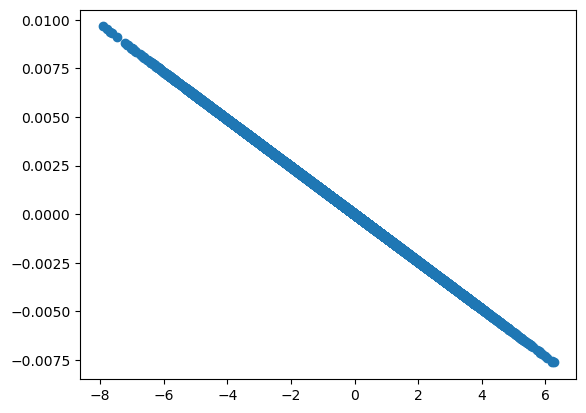

In [22]:
plt.scatter(Ubar, wbar_3m_c)

Text(0.5, 1.0, 'y = 0.00638*x + 0.00695')

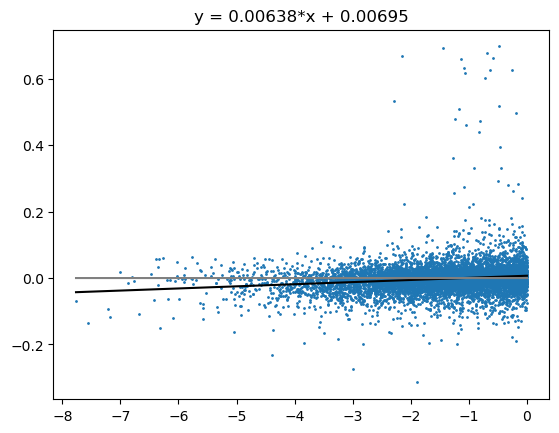

In [23]:


src = sos_ds.where(np.abs(sos_ds.dir_3m_c - 150) < 30).to_dataframe()[['u_3m_c', 'w_3m_c']].dropna()
plt.scatter(
    src['u_3m_c'],
    src['w_3m_c'],
    s=1
)
x = src['u_3m_c']
y = src['w_3m_c']
fitline = np.poly1d(np.polyfit(x, y, 1))
slope = fitline.coef[0]
intercept = fitline.coef[1]
plt.plot(np.unique(x), fitline(np.unique(x)), color='black')
plt.plot(np.unique(x), np.full(len(np.unique(x)), 0), color='grey')
plt.title(f"y = {round(slope, 5)}*x + {round(intercept, 5)}")

Text(0.5, 1.0, '10m, Tower uw')

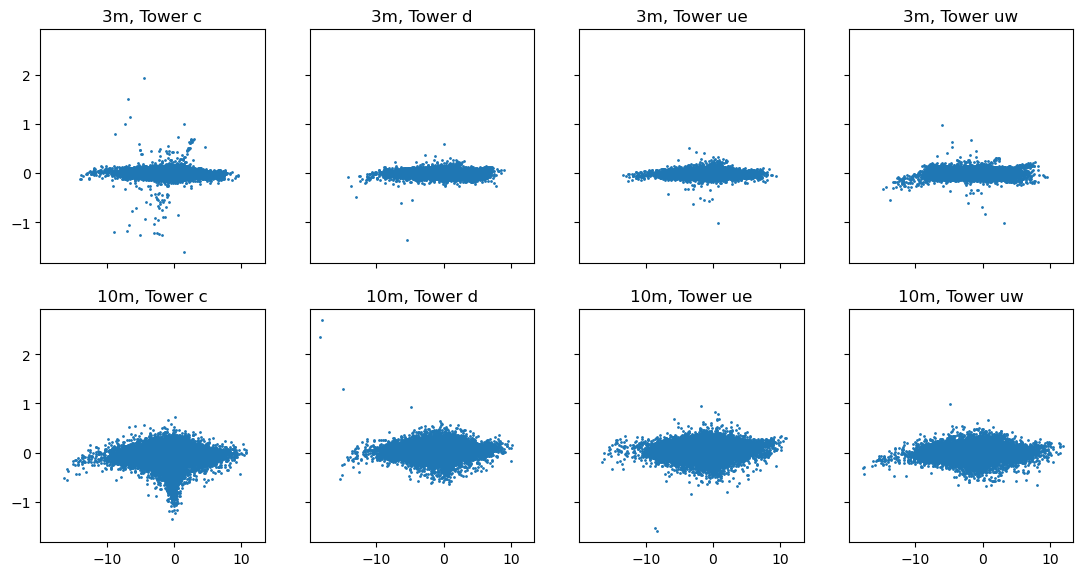

In [24]:
fig, axes = plt.subplots(2,4, figsize=(13.33,6.66), sharex=True, sharey=True)
axes[0,0].scatter(sos_ds['v_3m_c'],sos_ds['w_3m_c'],s=1)
axes[0,0].set_title('3m, Tower c')
axes[1,0].scatter(sos_ds['v_10m_c'],sos_ds['w_10m_c'],s=1)
axes[1,0].set_title('10m, Tower c')

axes[0,1].scatter(sos_ds['v_3m_d'],sos_ds['w_3m_d'],s=1)
axes[0,1].set_title('3m, Tower d')
axes[1,1].scatter(sos_ds['v_10m_d'],sos_ds['w_10m_d'],s=1)
axes[1,1].set_title('10m, Tower d')

axes[0,2].scatter(sos_ds['v_3m_ue'],sos_ds['w_3m_ue'],s=1)
axes[0,2].set_title('3m, Tower ue')
axes[1,2].scatter(sos_ds['v_10m_ue'],sos_ds['w_10m_ue'],s=1)
axes[1,2].set_title('10m, Tower ue')

axes[0,3].scatter(sos_ds['v_3m_uw'],sos_ds['w_3m_uw'],s=1)
axes[0,3].set_title('3m, Tower uw')
axes[1,3].scatter(sos_ds['v_10m_uw'],sos_ds['w_10m_uw'],s=1)
axes[1,3].set_title('10m, Tower uw')

# Replace fluxes with planar fitted fluxes

In [25]:
if PLANAR_FIT:
    planar_fitted_data_df = pd.read_parquet(planar_fitted_dir)
    planar_fitted_data_df = planar_fitted_data_df[[c for c in planar_fitted_data_df.columns if c.endswith('_fit')]]
    planar_fitted_data_df.columns = [c.replace('_fit', '') for c in planar_fitted_data_df.columns]
    planar_fitted_data_df = planar_fitted_data_df.loc[ start_date : end_date ]
    planar_fitted_ds = planar_fitted_data_df.to_xarray()
    sos_ds = sos_ds.assign(planar_fitted_ds)

In [26]:
PLANAR_FIT

True

In [27]:
src = sos_ds[[
    'w_1m_c',   'w_2m_c','w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    'w_1m_ue',  'w_3m_ue','w_10m_ue',
    'w_1m_uw',  'w_3m_uw','w_10m_uw',
    'w_1m_d',   'w_3m_d','w_10m_d',
]].resample(time='30min').mean()
src = tidy.get_tidy_dataset(src, list(src.data_vars))
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
alt.Chart(
    src
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)').scale(domain = [-0.02,0.02]),
    alt.Color('tower:N'),
    alt.Facet('height:O', columns=4),
    tooltip='variable',
).properties(width = 125, height = 125, title=    'Streamwise').display(renderer='svg')

alt.Chart(...)

In [28]:
src = sos_ds[[
    'w_1m_c',   'w_2m_c','w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    'w_1m_ue',  'w_3m_ue','w_10m_ue',
    'w_1m_uw',  'w_3m_uw','w_10m_uw',
    'w_1m_d',   'w_3m_d','w_10m_d',
]]
src = tidy.get_tidy_dataset(src, list(src.data_vars))
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
alt.Chart(
    src
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)').scale(domain = [-0.02,0.02]),
    alt.Color('tower:N'),
    alt.Facet('height:O', columns=4),
    tooltip='variable',
).properties(width = 250, height = 125, title=    'Streamwise').display(renderer='svg')

alt.Chart(...)

# Remove instrument-flagged data

Based on Stiperski and Rotach (2016, http://link.springer.com/10.1007/s10546-015-0103-z), who recommend the following steps as minimum quality criteria:

1. The sonic diagnostic flag was set high (malfunctioning of the instrument) inside the averaging period. 
2. KH20 voltage fell below 5 mV (indication of condensation occurring on the KH20 window).
3. Skewness of temperature and wind components fell outside the [-2, 2] range, following Vickers and Mahrt (1997).
4. Kurtosis of temperature and wind components was >8, following Vickers and Mahrt (1997).

We only implement number #2 and #3. We tried implementing #1, using the ldiag flag to remove sonic data, but it removed a lot of data, and, without using high rate data, we't cannot filter based on a "high" diagnostic flag, we can only filtering using the aggregate of all the flags (i.e. ldiag > 0). The 4th moments are not included in the 5-minute averages, so we cannot implement #4 without using the high rate data.

## Set bad Irga measurements to NaN

The NCAR report recommends all Irga-related measurements be set to NaN when irgadiag is non-zero.  They did this for some but not all of the data.

In [29]:
if CLEAN_FLAGGED_DATA:
    print('h2o_flux_var', 'irgadiag_var', 'old_nan_count_badirga', 'new_nan_count_badirga', 'old_mean', 'new_mean')
    var_ls = []
    old_nan_count_badirga_ls = []
    new_nan_count_badirga_ls = []
    old_mean_ls = []
    new_mean_ls = []
    old_median_ls = []
    new_median_ls = []
    for suffix in ec_measurement_suffixes:
        h2o_flux_var = 'w_h2o__' + suffix
        irgadiag_var = 'irgadiag_' + suffix
        
        old_nan_count_badirga = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        old_mean = sos_ds[h2o_flux_var].mean().item()
        old_median = sos_ds[h2o_flux_var].median().item()

        for prefix in ec_measurement_prefixes:
            var = prefix + suffix
            if var in sos_ds:
                sos_ds[var] = sos_ds[var].where(sos_ds[irgadiag_var] <= PERCENTAGE_IRGADIAG)
        # for prefix in [
        #     'h2o_', 'h2o_h2o__', 'u_h2o__', 'v_h2o__', 'w_h2o__',
        #     # I'M NOT SURE I WANT TO REMOVE THESE w_ MEASUREMENTS BUT I"M CURIOUS WHAT HAPPENS IF I DO
        #     'w_',
        # ]:


        new_nan_count_badirga = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        new_mean = sos_ds[h2o_flux_var].mean().item()
        new_median = sos_ds[h2o_flux_var].median().item()
        print(h2o_flux_var, irgadiag_var, old_nan_count_badirga, new_nan_count_badirga, round(old_mean,6), round(new_mean,6))
        var_ls.append(h2o_flux_var)
        old_nan_count_badirga_ls.append(old_nan_count_badirga)
        new_nan_count_badirga_ls.append(new_nan_count_badirga)
        old_mean_ls.append(old_mean)
        new_mean_ls.append(new_mean)
        old_median_ls.append(old_median)
        new_median_ls.append(new_median)

h2o_flux_var irgadiag_var old_nan_count_badirga new_nan_count_badirga old_mean new_mean
w_h2o__1m_ue irgadiag_1m_ue 42369 42416 0.010328 0.010334
w_h2o__2m_ue irgadiag_2m_ue 35279 35438 0.003893 0.003921
w_h2o__3m_ue irgadiag_3m_ue 6681 6807 0.007015 0.00701
w_h2o__10m_ue irgadiag_10m_ue 5591 5693 0.006601 0.006614
w_h2o__1m_d irgadiag_1m_d 40838 40880 0.009342 0.009378
w_h2o__2m_d irgadiag_2m_d 36632 36770 0.003448 0.003476
w_h2o__3m_d irgadiag_3m_d 6843 7001 0.00713 0.007166
w_h2o__10m_d irgadiag_10m_d 6166 6289 0.006731 0.006739
w_h2o__1m_uw irgadiag_1m_uw 46708 46729 0.012174 0.01217
w_h2o__2m_uw irgadiag_2m_uw 42772 42807 0.003301 0.003314
w_h2o__2_5m_uw irgadiag_2_5m_uw 57969 58011 0.00223 0.002221
w_h2o__3m_uw irgadiag_3m_uw 6345 6441 0.007221 0.007226
w_h2o__10m_uw irgadiag_10m_uw 7661 7806 0.006795 0.006858
w_h2o__1m_c irgadiag_1m_c 29045 29136 0.007821 0.007836
w_h2o__2m_c irgadiag_2m_c 4509 4629 0.006663 0.006681
w_h2o__3m_c irgadiag_3m_c 4635 4724 0.006907 0.006912
w_h2o__5

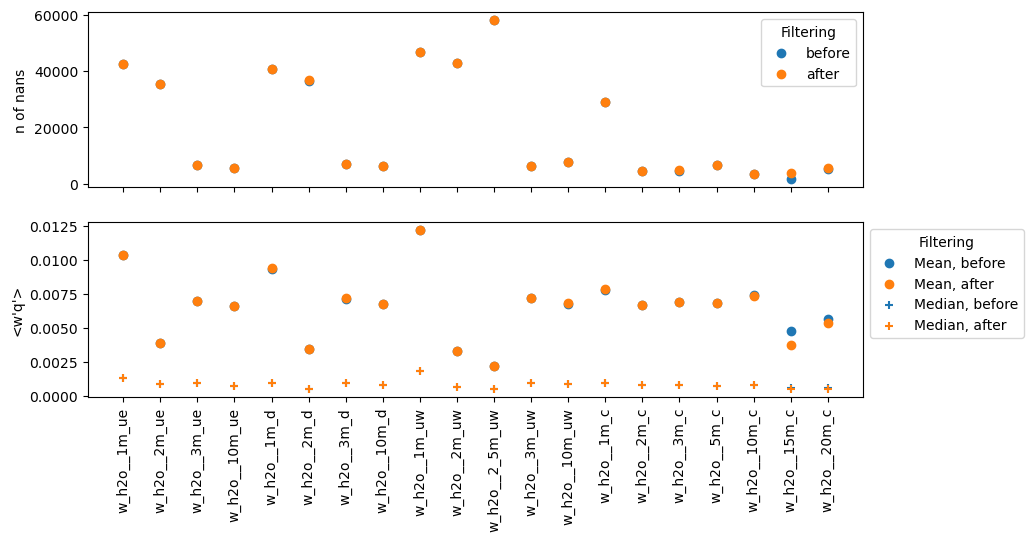

In [30]:
if CLEAN_FLAGGED_DATA:
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
    axes[0].scatter(var_ls, old_nan_count_badirga_ls, label = 'before', color='tab:blue')
    axes[0].set_ylabel("n of nans")
    axes[0].scatter(var_ls, new_nan_count_badirga_ls, label = 'after', color='tab:orange')

    axes[1].scatter(var_ls, old_mean_ls, label = 'Mean, before', color='tab:blue')
    axes[1].set_ylabel("<w'q'>")
    axes[1].scatter(var_ls, new_mean_ls, label = 'Mean, after', color='tab:orange')

    axes[1].scatter(var_ls, old_median_ls, label = 'Median, before', marker='+', color='tab:blue')
    axes[1].set_ylabel("<w'q'>")
    axes[1].scatter(var_ls, new_median_ls, label = 'Median, after', marker='+', color='tab:orange')

    for ax in axes:
        ax.tick_params(rotation=90, axis='x')
        ax.legend(title='Filtering', bbox_to_anchor=(1,1))

## Set bad Sonic measurements to Nan

In [31]:
if CLEAN_FLAGGED_DATA:
    print('h2o_flux_var', 'ldiag_var', 'old_nan_count_badsonic', 'new_nan_count_badsonic', 'old_mean', 'new_mean')

    var_ls = []
    old_nan_count_badsonic_ls = []
    new_nan_count_badsonic_ls = []
    old_mean_ls = []
    new_mean_ls = []
    for suffix in ec_measurement_suffixes:
        w_var = 'w_' + suffix
        h2o_flux_var = 'w_h2o__' + suffix
        sonicdiag_var = 'ldiag_' + suffix
        old_nan_count_badsonic = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        old_mean = sos_ds[h2o_flux_var].mean().item()
        
        # sos_ds[h2o_flux_var] = sos_ds[h2o_flux_var].where(sos_ds[sonicdiag_var] == 0)
        # sos_ds[w_var] = sos_ds[w_var].where(sos_ds[sonicdiag_var] == 0)
        for prefix in ec_measurement_prefixes:
            var = prefix + suffix
            if var in sos_ds:
                sos_ds[var] = sos_ds[var].where(sos_ds[sonicdiag_var] <= PERCENTAGE_SONICDIAG)

        new_nan_count_badsonic = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        new_mean = sos_ds[h2o_flux_var].mean().item()
        print(h2o_flux_var, sonicdiag_var, old_nan_count_badsonic, new_nan_count_badsonic, round(old_mean,6), round(new_mean,6))
        var_ls.append(h2o_flux_var)
        old_nan_count_badsonic_ls.append(old_nan_count_badsonic)
        new_nan_count_badsonic_ls.append(new_nan_count_badsonic)
        old_mean_ls.append(old_mean)
        new_mean_ls.append(new_mean)

h2o_flux_var ldiag_var old_nan_count_badsonic new_nan_count_badsonic old_mean new_mean
w_h2o__1m_ue ldiag_1m_ue 42416 42554 0.010334 0.010339
w_h2o__2m_ue ldiag_2m_ue 35438 35438 0.003921 0.003921
w_h2o__3m_ue ldiag_3m_ue 6807 7026 0.00701 0.007007
w_h2o__10m_ue ldiag_10m_ue 5693 5855 0.006614 0.006575
w_h2o__1m_d ldiag_1m_d 40880 41104 0.009378 0.009345
w_h2o__2m_d ldiag_2m_d 36770 36770 0.003476 0.003476
w_h2o__3m_d ldiag_3m_d 7001 7177 0.007166 0.007131
w_h2o__10m_d ldiag_10m_d 6289 6393 0.006739 0.006705
w_h2o__1m_uw ldiag_1m_uw 46729 46936 0.01217 0.01223
w_h2o__2m_uw ldiag_2m_uw 42807 42807 0.003314 0.003314
w_h2o__2_5m_uw ldiag_2_5m_uw 58011 58011 0.002221 0.002221
w_h2o__3m_uw ldiag_3m_uw 6441 6629 0.007226 0.00717
w_h2o__10m_uw ldiag_10m_uw 7806 7883 0.006858 0.00682
w_h2o__1m_c ldiag_1m_c 29136 29318 0.007836 0.007835
w_h2o__2m_c ldiag_2m_c 4629 4811 0.006681 0.006644
w_h2o__3m_c ldiag_3m_c 4724 5011 0.006912 0.006885
w_h2o__5m_c ldiag_5m_c 6803 7034 0.006851 0.006839
w_h2o__

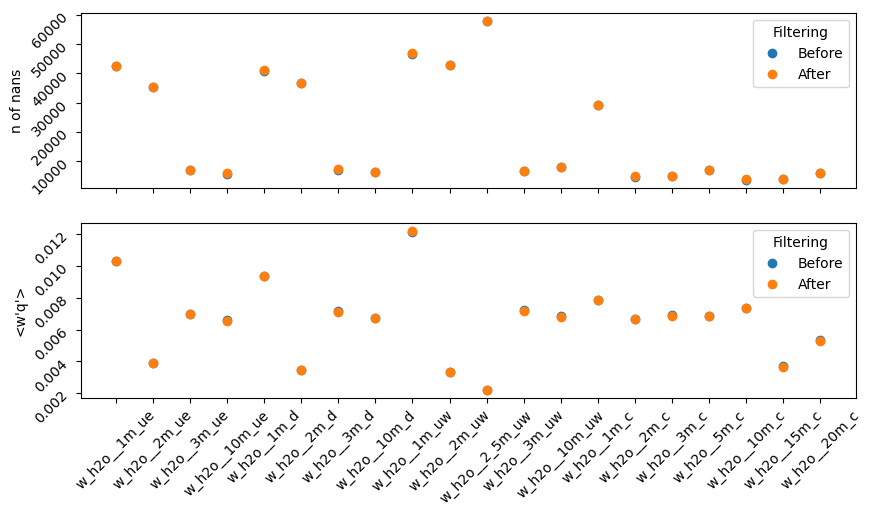

In [32]:
if CLEAN_FLAGGED_DATA:
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
    axes[0].scatter(var_ls, old_nan_count_badsonic_ls, label = 'Before')
    axes[0].set_ylabel("n of nans")
    axes[0].scatter(var_ls, new_nan_count_badsonic_ls, label = 'After')

    axes[1].scatter(var_ls, old_mean_ls, label = 'Before')
    axes[1].set_ylabel("<w'q'>")
    axes[1].scatter(var_ls, new_mean_ls, label = 'After')

    for ax in axes:
        ax.tick_params(rotation=45)
        ax.legend(title='Filtering')

# Interpolate missing EC variables up to 1 hour

In [33]:
if CLEAN_FLAGGED_DATA:
    print('h2o_flux_var', 'ldiag_var', 'old_nan_count_afterfilling', 'new_nan_count_afterfilling', 'old_mean', 'new_mean')

    var_ls = []
    old_nan_count_afterfilling_ls = []
    new_nan_count_afterfilling_ls = []
    old_mean_ls = []
    new_mean_ls = []
    for suffix in ec_measurement_suffixes:
        w_var = 'w_' + suffix
        h2o_flux_var = 'w_h2o__' + suffix
        sonicdiag_var = 'ldiag_' + suffix
        old_nan_count_afterfilling = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        old_mean = sos_ds[h2o_flux_var].mean().item()
        
        for prefix in ec_measurement_prefixes:
            var = prefix + suffix
            if var in sos_ds:
                sos_ds[var] = sos_ds[var].interpolate_na(dim='time', method='linear', limit=12)

        new_nan_count_afterfilling = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        new_mean = sos_ds[h2o_flux_var].mean().item()
        print(h2o_flux_var, sonicdiag_var, old_nan_count_afterfilling, new_nan_count_afterfilling, round(old_mean,6), round(new_mean,6))
        var_ls.append(h2o_flux_var)
        old_nan_count_afterfilling_ls.append(old_nan_count_afterfilling)
        new_nan_count_afterfilling_ls.append(new_nan_count_afterfilling)
        old_mean_ls.append(old_mean)
        new_mean_ls.append(new_mean)

h2o_flux_var ldiag_var old_nan_count_afterfilling new_nan_count_afterfilling old_mean new_mean
w_h2o__1m_ue ldiag_1m_ue 42554 41731 0.010339 0.010058
w_h2o__2m_ue ldiag_2m_ue 35438 34606 0.003921 0.003897
w_h2o__3m_ue ldiag_3m_ue 7026 5305 0.007007 0.006892
w_h2o__10m_ue ldiag_10m_ue 5855 4249 0.006575 0.006447
w_h2o__1m_d ldiag_1m_d 41104 40704 0.009345 0.00933
w_h2o__2m_d ldiag_2m_d 36770 36205 0.003476 0.003385
w_h2o__3m_d ldiag_3m_d 7177 5427 0.007131 0.00696
w_h2o__10m_d ldiag_10m_d 6393 4708 0.006705 0.006648
w_h2o__1m_uw ldiag_1m_uw 46936 46292 0.01223 0.011995
w_h2o__2m_uw ldiag_2m_uw 42807 42118 0.003314 0.003249
w_h2o__2_5m_uw ldiag_2_5m_uw 58011 57728 0.002221 0.001943
w_h2o__3m_uw ldiag_3m_uw 6629 5151 0.00717 0.007046
w_h2o__10m_uw ldiag_10m_uw 7883 6045 0.00682 0.006721
w_h2o__1m_c ldiag_1m_c 29318 28432 0.007835 0.007729
w_h2o__2m_c ldiag_2m_c 4811 3756 0.006644 0.006592
w_h2o__3m_c ldiag_3m_c 5011 3833 0.006885 0.006868
w_h2o__5m_c ldiag_5m_c 7034 6244 0.006839 0.006848

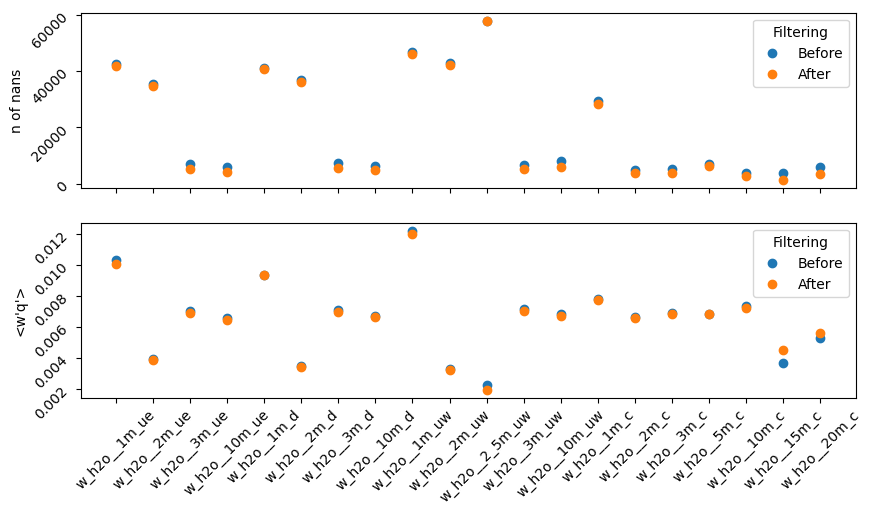

In [34]:
if CLEAN_FLAGGED_DATA:
    fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
    axes[0].scatter(var_ls, old_nan_count_afterfilling_ls, label = 'Before')
    axes[0].set_ylabel("n of nans")
    axes[0].scatter(var_ls, new_nan_count_afterfilling_ls, label = 'After')

    axes[1].scatter(var_ls, old_mean_ls, label = 'Before')
    axes[1].set_ylabel("<w'q'>")
    axes[1].scatter(var_ls, new_mean_ls, label = 'After')

    for ax in axes:
        ax.tick_params(rotation=45)
        ax.legend(title='Filtering')

In [35]:
if CLEAN_FLAGGED_DATA:
    nan_counts_df = pd.DataFrame({
        'variable':                     var_ls,
        'n':                            len(sos_ds.time),
        'original nan count':           old_nan_count_badirga_ls, 
        'nans after bad irga removed':  new_nan_count_badirga_ls, 
        'nans after bad sonic removed': new_nan_count_badsonic_ls, 
        'nans after gap filling':       new_nan_count_afterfilling_ls,
    })
    limited_nan_counts_df = nan_counts_df[ 
        (~nan_counts_df.variable.str.contains('__1m_'))
        
        &
        (~nan_counts_df.variable.str.contains('__2_5m_'))
    ]
    limited_nan_counts_df

In [36]:
if CLEAN_FLAGGED_DATA:
    limited_nan_counts_df['Data removed by EC150 flag'] = limited_nan_counts_df['nans after bad irga removed'] - limited_nan_counts_df['original nan count']
    limited_nan_counts_df['Data removed by CSAT3 flag'] = limited_nan_counts_df['nans after bad sonic removed'] - limited_nan_counts_df['nans after bad irga removed']
    limited_nan_counts_df[[
        'variable',
        'n',
        'Data removed by EC150 flag',
        'Data removed by CSAT3 flag'
    ]]

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_17900/166689026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_nan_counts_df['Data removed by EC150 flag'] = limited_nan_counts_df['nans after bad irga removed'] - limited_nan_counts_df['original nan count']
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_17900/166689026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_nan_counts_df['Data removed by CSAT3 flag'] = limited_nan_counts_df['nans after bad sonic removed

In [46]:
limited_nan_counts_df

,variable,n,original nan count,nans after bad irga removed,nans after bad sonic removed,nans after gap filling,Data removed by EC150 flag,Data removed by CSAT3 flag
1,w_h2o__2m_ue,66528,35279,35438,35438,34606,159,0
2,w_h2o__3m_ue,66528,6681,6807,7026,5305,126,219
3,w_h2o__10m_ue,66528,5591,5693,5855,4249,102,162
5,w_h2o__2m_d,66528,36632,36770,36770,36205,138,0
6,w_h2o__3m_d,66528,6843,7001,7177,5427,158,176
7,w_h2o__10m_d,66528,6166,6289,6393,4708,123,104
9,w_h2o__2m_uw,66528,42772,42807,42807,42118,35,0
11,w_h2o__3m_uw,66528,6345,6441,6629,5151,96,188
12,w_h2o__10m_uw,66528,7661,7806,7883,6045,145,77
14,w_h2o__2m_c,66528,4509,4629,4811,3756,120,182


In [37]:
if CLEAN_FLAGGED_DATA:
    src = sos_ds[['SF_avg_1m_ue', 'SF_avg_2m_ue', 'ldiag_3m_c']].to_dataframe().reset_index()
    src['SF_avg_ue'] = src['SF_avg_1m_ue'] + src['SF_avg_2m_ue']
    src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
    src['on Dec 21/22'] = (src.time.dt.date == dt.date(2022,12,22)) | (src.time.dt.date == dt.date(2022,12,21))
    src = src.query("SF_avg_ue > 0")
    rule = alt.Chart().transform_calculate(rule = '0.1').mark_rule(strokeDash=[2,2]).encode(y='rule:Q')
    bad_sonic_data = (
        rule + alt.Chart(src).mark_circle(size=10).encode(
            alt.X("SF_avg_ue").title("Blowing snow flux (g/m^2/s)").scale(type='log'),
            alt.Y("ldiag_3m_c").title(["Fraction of 20hz sonic anemometer", "measurements flagged (Tower C, 3m)"]),
            alt.Color("on Dec 21/22:N")
        ).properties(width=200, height=200)
    ).configure_axis(grid=False).configure_legend(columns=2, orient='top')
    bad_sonic_data.save("bad_sonic_data.png", ppi=200)
    bad_sonic_data

In [38]:
if CLEAN_FLAGGED_DATA:
    src.query("ldiag_3m_c > 0.1")['on Dec 21/22'].value_counts()

In [39]:
if CLEAN_FLAGGED_DATA:
    src = sos_ds[['RH_3m_c', 'RH_20m_c', 'irgadiag_3m_c', 'irgadiag_20m_c']].to_dataframe().reset_index()
    src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')

    bad_irga_data_3m = (
        alt.Chart(src).mark_circle(size=10).encode(
            alt.X("RH_3m_c:Q").title("Relative humidity, 3m (%)"),
            alt.Y("irgadiag_3m_c:Q").title(["Sum of EC150 diagnostic flags", "3m"]).scale(type='linear'),
        ).properties(width=200, height=200)
    )
    bad_irga_data_20m = (
        alt.Chart(src).mark_circle(size=10).encode(
            alt.X("RH_20m_c:Q").title("Relative humidity, 20m (%)"),
            alt.Y("irgadiag_20m_c:Q").title(["Sum of EC150 diagnostic flags", "20m"]).scale(type='linear'),
        ).properties(width=200, height=200)
    )
    bad_irga_data = (bad_irga_data_3m | bad_irga_data_20m).configure_axis(grid=False)
    bad_irga_data.save("bad_irga_data.png", ppi=200)
    bad_irga_data

# Resample dataset

## Define dictionary defining the resampling function to use for each variable

Covariances are resampled according to the rules of **Reynold averaging** (https://www.eol.ucar.edu/content/combining-short-term-moments-longer-time-periods).

Meteorological and turbulence measurements (other than covariances) are resampled using the **mean**.

EC count variables are **summed**.

In [40]:
data_vars_processing_dict = {
    'reynolds_average': [
        'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_co2__1m_uw', 'u_h2o__1m_uw',  'v_co2__1m_uw', 'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_co2__1m_uw', 'w_h2o__1m_uw',
        'u_u__2m_uw',    'v_v__2m_uw',    'w_w__2m_uw',    'u_w__2m_uw',    'v_w__2m_uw',  'u_tc__2m_uw',  'v_tc__2m_uw',   'u_co2__2m_uw', 'u_h2o__2m_uw',  'v_co2__2m_uw', 'v_h2o__2m_uw',   'w_tc__2m_uw',   'w_co2__2m_uw', 'w_h2o__2m_uw',
        'u_u__2_5m_uw', 'v_v__2_5m_uw',   'w_w__2_5m_uw',  'u_w__2_5m_uw',  'v_w__2_5m_uw','u_tc__2_5m_uw','v_tc__2_5m_uw', 'u_co2__2_5m_uw', 'u_h2o__2_5m_uw','v_h2o__2_5m_uw', 'w_tc__2_5m_uw', 'w_co2__2_5m_uw', 'w_h2o__2_5m_uw',
        'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_co2__3m_uw', 'u_h2o__3m_uw',  'v_co2__3m_uw', 'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_co2__3m_uw', 'w_h2o__3m_uw',
        'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_co2__10m_uw', 'u_h2o__10m_uw', 'v_co2__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_co2__10m_uw', 'w_h2o__10m_uw',
        'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_co2__1m_ue', 'u_h2o__1m_ue',  'v_co2__1m_ue', 'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_co2__1m_ue', 'w_h2o__1m_ue',
        'u_u__2m_ue',    'v_v__2m_ue',    'w_w__2m_ue',    'u_w__2m_ue',    'v_w__2m_ue',  'u_tc__2m_ue',  'v_tc__2m_ue',   'u_co2__2m_ue', 'u_h2o__2m_ue',  'v_co2__2m_ue', 'v_h2o__2m_ue',   'w_tc__2m_ue',   'w_co2__2m_ue', 'w_h2o__2m_ue',
        'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_co2__3m_ue', 'u_h2o__3m_ue',  'v_co2__3m_ue', 'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_co2__3m_ue', 'w_h2o__3m_ue',
        'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_co2__10m_ue', 'u_h2o__10m_ue', 'v_co2__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_co2__10m_ue', 'w_h2o__10m_ue',
        'u_u__1m_d',     'v_v__1m_d',     'w_w__1m_d',     'u_w__1m_d',     'v_w__1m_d',   'u_tc__1m_d',   'v_tc__1m_d',    'u_co2__1m_d', 'u_h2o__1m_d',   'v_co2__1m_d', 'v_h2o__1m_d',    'w_tc__1m_d',    'w_co2__1m_d', 'w_h2o__1m_d',
        'u_u__2m_d',     'v_v__2m_d',     'w_w__2m_d',     'u_w__2m_d',     'v_w__2m_d',   'u_tc__2m_d',   'v_tc__2m_d',    'u_co2__2m_d', 'u_h2o__2m_d',   'v_co2__2m_d', 'v_h2o__2m_d',    'w_tc__2m_d',    'w_co2__2m_d', 'w_h2o__2m_d',
        'u_u__3m_d',     'v_v__3m_d',     'w_w__3m_d',     'u_w__3m_d',     'v_w__3m_d',   'u_tc__3m_d',   'v_tc__3m_d',    'u_co2__3m_d', 'u_h2o__3m_d',   'v_co2__3m_d', 'v_h2o__3m_d',    'w_tc__3m_d',    'w_co2__3m_d', 'w_h2o__3m_d',
        'u_u__10m_d',    'v_v__10m_d',    'w_w__10m_d',    'u_w__10m_d',    'v_w__10m_d',  'u_tc__10m_d',  'v_tc__10m_d',   'u_co2__10m_d', 'u_h2o__10m_d',  'v_co2__10m_d', 'v_h2o__10m_d',   'w_tc__10m_d',   'w_co2__10m_d', 'w_h2o__10m_d',
        'u_u__1m_c',     'v_v__1m_c',     'w_w__1m_c',     'u_w__1m_c',     'v_w__1m_c',   'u_tc__1m_c',   'v_tc__1m_c',    'u_co2__1m_c', 'u_h2o__1m_c',   'v_co2__1m_c', 'v_h2o__1m_c',    'w_tc__1m_c',    'w_co2__1m_c', 'w_h2o__1m_c',
        'u_u__2m_c',     'v_v__2m_c',     'w_w__2m_c',     'u_w__2m_c',     'v_w__2m_c',   'u_tc__2m_c',   'v_tc__2m_c',    'u_co2__2m_c', 'u_h2o__2m_c',   'v_co2__2m_c', 'v_h2o__2m_c',    'w_tc__2m_c',    'w_co2__2m_c', 'w_h2o__2m_c',
        'u_u__3m_c',     'v_v__3m_c',     'w_w__3m_c',     'u_w__3m_c',     'v_w__3m_c',   'u_tc__3m_c',   'v_tc__3m_c',    'u_co2__3m_c', 'u_h2o__3m_c',   'v_co2__3m_c', 'v_h2o__3m_c',    'w_tc__3m_c',    'w_co2__3m_c', 'w_h2o__3m_c',
        'u_u__5m_c',     'v_v__5m_c',     'w_w__5m_c',     'u_w__5m_c',     'v_w__5m_c',   'u_tc__5m_c',   'v_tc__5m_c',    'u_co2__5m_c', 'u_h2o__5m_c',   'v_co2__5m_c', 'v_h2o__5m_c',    'w_tc__5m_c',    'w_co2__5m_c', 'w_h2o__5m_c',
        'u_u__10m_c',    'v_v__10m_c',    'w_w__10m_c',    'u_w__10m_c',    'v_w__10m_c',  'u_tc__10m_c',  'v_tc__10m_c',   'u_co2__10m_c', 'u_h2o__10m_c',  'v_co2__10m_c', 'v_h2o__10m_c',   'w_tc__10m_c',   'w_co2__10m_c', 'w_h2o__10m_c',
        'u_u__15m_c',    'v_v__15m_c',    'w_w__15m_c',    'u_w__15m_c',    'v_w__15m_c',  'u_tc__15m_c',  'v_tc__15m_c',   'u_co2__15m_c', 'u_h2o__15m_c',  'v_co2__15m_c', 'v_h2o__15m_c',   'w_tc__15m_c',   'w_co2__15m_c', 'w_h2o__15m_c',
        'u_u__20m_c',    'v_v__20m_c',    'w_w__20m_c',    'u_w__20m_c',    'v_w__20m_c',  'u_tc__20m_c',  'v_tc__20m_c',   'u_co2__20m_c', 'u_h2o__20m_c',  'v_co2__20m_c', 'v_h2o__20m_c',   'w_tc__20m_c',   'w_co2__20m_c', 'w_h2o__20m_c',
    ],
    'average': [
        # Sonic anemometer data
        'co2_1m_uw', 'h2o_1m_uw' ,       'tc_1m_uw',     'spd_1m_uw',    'u_1m_uw',  'v_1m_uw',   'w_1m_uw',  
        'co2_3m_uw', 'h2o_3m_uw' ,       'tc_3m_uw',     'spd_3m_uw',    'u_3m_uw',  'v_3m_uw',   'w_3m_uw',  
        'co2_10m_uw', 'h2o_10m_uw' ,      'tc_10m_uw',    'spd_10m_uw',   'u_10m_uw', 'v_10m_uw',  'w_10m_uw',  
        'co2_1m_ue', 'h2o_1m_ue' ,       'tc_1m_ue',     'spd_1m_ue',    'u_1m_ue',  'v_1m_ue',   'w_1m_ue',  
        'co2_3m_ue', 'h2o_3m_ue' ,       'tc_3m_ue',     'spd_3m_ue',    'u_3m_ue',  'v_3m_ue',   'w_3m_ue',  
        'co2_10m_ue', 'h2o_10m_ue' ,      'tc_10m_ue',    'spd_10m_ue',   'u_10m_ue', 'v_10m_ue',  'w_10m_ue',  
        'co2_1m_d', 'h2o_1m_d' ,        'tc_1m_d',      'spd_1m_d',     'u_1m_d',   'v_1m_d',    'w_1m_d',  
        'co2_3m_d', 'h2o_3m_d' ,        'tc_3m_d',      'spd_3m_d',     'u_3m_d',   'v_3m_d',    'w_3m_d',  
        'co2_10m_d', 'h2o_10m_d' ,       'tc_10m_d',     'spd_10m_d',    'u_10m_d',  'v_10m_d',   'w_10m_d',  
        'co2_1m_c', 'h2o_1m_c' ,        'tc_1m_c',      'spd_1m_c',     'u_1m_c',   'v_1m_c',    'w_1m_c',  
        'co2_2m_c', 'h2o_2m_c' ,        'tc_2m_c',      'spd_2m_c',     'u_2m_c',   'v_2m_c',    'w_2m_c',  
        'co2_3m_c', 'h2o_3m_c' ,        'tc_3m_c',      'spd_3m_c',     'u_3m_c',   'v_3m_c',    'w_3m_c',  
        'co2_5m_c', 'h2o_5m_c' ,        'tc_5m_c',      'spd_5m_c',     'u_5m_c',   'v_5m_c',    'w_5m_c',  
        'co2_10m_c', 'h2o_10m_c' ,       'tc_10m_c',     'spd_10m_c',    'u_10m_c',  'v_10m_c',   'w_10m_c',  
        'co2_15m_c', 'h2o_15m_c' ,       'tc_15m_c',     'spd_15m_c',    'u_15m_c',  'v_15m_c',   'w_15m_c',  
        'co2_20m_c', 'h2o_20m_c' ,       'tc_20m_c',     'spd_20m_c',    'u_20m_c',  'v_20m_c',   'w_20m_c',  

        # Temperature & Relative Humidity Array 
        'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
        'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

        'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
        'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

        # Pressure Sensors
        'P_20m_c',
        'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

        # Blowing snow/FlowCapt Sensors
        'SF_avg_1m_ue', 'SF_avg_2m_ue',

        # Apogee sensors
        "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
        "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
        "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

        # Snow-level temperature arrays (towers D and UW)
        'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
        'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
        
        # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
        'Rpile_out_9m_d',
        'Tcase_out_9m_d',    
        # Upward Facing Longwave Radiometer (tower D)
        'Rpile_in_9m_d',
        'Tcase_in_9m_d',
        # Downward Facing Longwave Radiometer (tower UW) - for measuring snow surface temperature
        'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
        
        # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
        'Rsw_in_9m_d',
        'Rsw_out_9m_d',

        # Snow Pillow SWE
        'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

        # Soil Moisture
        'Qsoil_d',

        # Soil Moisture
        'Gsoil_d',
        
        # Diagnostic variables for irga and sonic
        'irgadiag_1m_c',    'ldiag_1m_c',
        'irgadiag_2m_c',    'ldiag_2m_c',
        'irgadiag_3m_c',    'ldiag_3m_c',
        'irgadiag_5m_c',    'ldiag_5m_c',
        'irgadiag_10m_c',   'ldiag_10m_c',
        'irgadiag_15m_c',   'ldiag_15m_c',
        'irgadiag_20m_c',   'ldiag_20m_c',
        'irgadiag_1m_uw',   'ldiag_1m_uw',
        'irgadiag_3m_uw',   'ldiag_3m_uw',
        'irgadiag_10m_uw',  'ldiag_10m_uw',
        'irgadiag_1m_ue',   'ldiag_1m_ue',
        'irgadiag_3m_ue',   'ldiag_3m_ue',
        'irgadiag_10m_ue',  'ldiag_10m_ue',
        'irgadiag_1m_d',    'ldiag_1m_d',
        'irgadiag_3m_d',    'ldiag_3m_d',
        'irgadiag_10m_d',   'ldiag_10m_d',

    ],
    'median' : [
        'dir_1m_uw',    
        'dir_3m_uw',    
        'dir_10m_uw',   
        'dir_1m_ue',    
        'dir_3m_ue',    
        'dir_10m_ue',   
        'dir_1m_d',     
        'dir_3m_d',     
        'dir_10m_d',    
        'dir_1m_c',     
        'dir_2m_c',     
        'dir_3m_c',     
        'dir_5m_c',     
        'dir_10m_c',    
        'dir_15m_c',    
        'dir_20m_c',    
    ],
    'sum' : [
        # Counts of unflagged instantaneous (20hz) eddy covariance measurements
        # momentum flux flags   LHFlux flags   SH flux flags       
        'counts_1m_c',    'counts_1m_c_1',    'counts_1m_c_2',    
        'counts_2m_c',    'counts_2m_c_1',    'counts_2m_c_2',    
        'counts_3m_c',    'counts_3m_c_1',    'counts_3m_c_2',    
        'counts_5m_c',    'counts_5m_c_1',    'counts_5m_c_2',    
        'counts_10m_c',   'counts_10m_c_1',   'counts_10m_c_2',   
        'counts_15m_c',   'counts_15m_c_1',   'counts_15m_c_2',   
        'counts_20m_c',   'counts_20m_c_1',   'counts_20m_c_2',   
        'counts_1m_uw',   'counts_1m_uw_1',   'counts_1m_uw_2',   
        'counts_3m_uw',   'counts_3m_uw_1',   'counts_3m_uw_2',   
        'counts_10m_uw',  'counts_10m_uw_1',  'counts_10m_uw_2',  
        'counts_1m_ue',   'counts_1m_ue_1',   'counts_1m_ue_2',   
        'counts_3m_ue',   'counts_3m_ue_1',   'counts_3m_ue_2',   
        'counts_10m_ue',  'counts_10m_ue_1',  'counts_10m_ue_2',  
        'counts_1m_d',    'counts_1m_d_1',    'counts_1m_d_2',    
        'counts_3m_d',    'counts_3m_d_1',    'counts_3m_d_2',    
        'counts_10m_d',   'counts_10m_d_1',   'counts_10m_d_2',   
    ]
}

## Define function for resampling covariances

In [41]:
def separate_covariance_variable_name(cov_name):
    """Get the names of the two mean variables associated with a covariance variable. Built to use
    with SOS datasets. For example, one might provide `w_h2o__3m_c` and this function will return
    `w_3m_c` and `h2o_3m_c`.

    Args:
        cov_name (str): name of variable that you want to separate into the two names of the 
        asssociated mean variables.

    Returns:
        var1, var 2 (str, str): two strings with the names of the two mean variables
    """
    [first_parts, second_part] = cov_name.split('__')
    [var1, var2] = first_parts.split('_')
    [var1, var2] = [
        var1 +'_' + second_part,
        var2 +'_' + second_part,
    ]
    return var1, var2

def resample_moment(df, cov, mean1, mean2, new_frequency, n_in_new_re_length, skipna=True):
    """Combines moments into longer time periods, using reynolds averaging. Built to use with SOS 
    datasets. Resampling covariances which have been calculated for a specific Reynolds
    averaging length (e.g. the SOS datasets are averaged to 5minutes), you need both the mean
    values and covariance. For example, the variable `w_h2o__3m_c` is associated with mean values
    `w_3m_c` and `h2o_3m_c`. To reasmple `w_h2o__3m_c` to another averaging length, we need the three
    variables.

    Args:
        df (pd.Dataframe): Dataframe containing the three columns required for calculations (contains)
                    the names supplied as parameters `cov`, `mean1`, and `mean2`.
        cov (str): Name of covariance variable to resample using Reynolds averaing
        mean1 (str): Name of one of the two mean variables associated with `cov`
        mean2 (str): Name of the other mean variable associated with `cov`
        new_frequency (str): String interpretable by pandas/xarray that describes the reynolds length you 
            are resampling to. EG: '60Min'
        n_in_new_re_length (_type_): Number of 5 minute intervals that fit in the new_frequency. E.G. for
            new_frequency='60Min', you would provide 12.
        skipna (bool, optional): Whether to skip NaNs when calculating the new variables. Providing True
            will allow more moments to be calculated, but those moments may be inaccurate/non-representative.
            Providing False will result in more missing data.

    Returns:
        pd.DataFrame: Dataframe with resampled data.
    """
    return pd.DataFrame({
            cov: df.groupby(pd.Grouper(freq=new_frequency)).apply(
                lambda row: 
                    (1/n_in_new_re_length)*(row[cov] + row[mean1]*row[mean2]).sum(skipna=skipna)
                    - (
                        (1/n_in_new_re_length)*row[mean1].sum(skipna=skipna)
                        * (1/n_in_new_re_length)*row[mean2].sum(skipna=skipna)
                    )
            )
        })

def resample(ds, new_frequency, n_in_new_re_length, skipna=True):
    """Resample SOS xarray datasets, applying the proper aggregation function
    for different variables. Some are resampled by taking the mean, some by 
    summing, and others by Reynolds averaging. 
    """
    # Resample data vars that need to be averaged (plain old averaging)
    # Use built in xarray functionality
    resampled_averages = ds[
        data_vars_processing_dict['average']
    ].to_dataframe().resample(new_frequency).mean().to_xarray()

    resampled_medians = ds[
        data_vars_processing_dict['median']
    ].to_dataframe().resample(new_frequency).median().to_xarray()
    
    # Resample data vars that need to be summed
    # Use built in xarray functionality
    resampled_sums = ds[
        data_vars_processing_dict['sum']
    ].to_dataframe().resample(new_frequency).sum().to_xarray()
    
    # Resample data vars that need to be summed using the rules of Reynolds Averaging
    # Use our custom function defined above
    resampled_reynolds_averages_list = []
    def split_covariance_name_and_resample(name):
        mean_var1, mean_var2 = separate_covariance_variable_name(name)
        resampled = resample_moment(
            ds[[mean_var1, mean_var2, name]].to_dataframe(), 
            name, 
            mean_var1, 
            mean_var2, 
            new_frequency, 
            n_in_new_re_length, 
            skipna=skipna
        )
        return resampled.to_xarray()
    resampled_reynolds_averages_list =  Parallel(n_jobs = 8)(
        delayed(split_covariance_name_and_resample)(name) 
        for name in tqdm(data_vars_processing_dict['reynolds_average'])
    )
    
    new_ds = xr.merge(
        [
            resampled_sums, 
            resampled_medians,
            resampled_averages
        ] + resampled_reynolds_averages_list
    )

    ## Copy attributes from the original dataset
    new_ds.attrs = ds.attrs
    for var in new_ds:
        new_ds[var].attrs = ds[var].attrs
    return new_ds

## Resample variables

In [42]:
sos_ds10min = resample(sos_ds, '10Min', 2, skipna=True)
sos_ds30min = resample(sos_ds, '30Min', 6, skipna=True)
sos_ds60min = resample(sos_ds, '60Min', 12, skipna=True)
sos_ds120min = resample(sos_ds, '120Min', 24, skipna=True)

sos_ds5min = sos_ds

  9%|▊         | 24/279 [00:09<01:57,  2.17it/s]/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
  9%|▊         | 24/279 [00:05<01:19,  3.21it/s]/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
  6%|▌         | 16/279 [00:01<00:18, 14.45it/s]/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warning

In [43]:
del sos_ds

# Save datasets at other resolutions

In [44]:
from sublimpy import tidy

# 5 minutes
tidy_df_5min = tidy.get_tidy_dataset(sos_ds5min, list(sos_ds5min.data_vars))
tidy_df_5min.to_parquet('tidy_df_5min.parquet')

tidy_df_10min = tidy.get_tidy_dataset(sos_ds10min, list(sos_ds10min.data_vars))
tidy_df_10min.to_parquet('tidy_df_10min.parquet')

In [45]:
ls -lah tidy_df_5min.parquet
ls -lah tidy_df_10min.parquet

SyntaxError: invalid syntax (3718279652.py, line 1)

## Count nans for lhflux variables in the 60min resampled data

In [47]:
for suffix in ec_measurement_suffixes:
    h2o_flux_var = 'w_h2o__' + suffix
    print(h2o_flux_var, sos_ds60min[h2o_flux_var].isnull().sum())

w_h2o__1m_ue <xarray.DataArray 'w_h2o__1m_ue' ()> Size: 8B
array(0)
w_h2o__2m_ue <xarray.DataArray 'w_h2o__2m_ue' ()> Size: 8B
array(0)
w_h2o__3m_ue <xarray.DataArray 'w_h2o__3m_ue' ()> Size: 8B
array(0)
w_h2o__10m_ue <xarray.DataArray 'w_h2o__10m_ue' ()> Size: 8B
array(0)
w_h2o__1m_d <xarray.DataArray 'w_h2o__1m_d' ()> Size: 8B
array(0)
w_h2o__2m_d <xarray.DataArray 'w_h2o__2m_d' ()> Size: 8B
array(0)
w_h2o__3m_d <xarray.DataArray 'w_h2o__3m_d' ()> Size: 8B
array(0)
w_h2o__10m_d <xarray.DataArray 'w_h2o__10m_d' ()> Size: 8B
array(0)
w_h2o__1m_uw <xarray.DataArray 'w_h2o__1m_uw' ()> Size: 8B
array(0)
w_h2o__2m_uw <xarray.DataArray 'w_h2o__2m_uw' ()> Size: 8B
array(0)
w_h2o__2_5m_uw <xarray.DataArray 'w_h2o__2_5m_uw' ()> Size: 8B
array(0)
w_h2o__3m_uw <xarray.DataArray 'w_h2o__3m_uw' ()> Size: 8B
array(0)
w_h2o__10m_uw <xarray.DataArray 'w_h2o__10m_uw' ()> Size: 8B
array(0)
w_h2o__1m_c <xarray.DataArray 'w_h2o__1m_c' ()> Size: 8B
array(0)
w_h2o__2m_c <xarray.DataArray 'w_h2o__2m_c' ()> 

# Test for stationarity

Following https://link.springer.com/10.1007/978-3-030-52171-4_55, http://link.springer.com/10.1007/s10546-015-0103-zz

In [48]:
data30min_matching_5min = (np.array([
    sos_ds30min[var].values,
    sos_ds30min[var].values,
    sos_ds30min[var].values,
    sos_ds30min[var].values,
    sos_ds30min[var].values,
    sos_ds30min[var].values,
]).T).flatten()

data30min_matching_5min
stationary_stat =  100 * (data30min_matching_5min - sos_ds5min[var].values) / data30min_matching_5min


See equation 55.16 in https://link.springer.com/10.1007/978-3-030-52171-4_55

In [49]:
if CLEAN_FLAGGED_DATA:
    for var in limited_nan_counts_df.variable:
        w_h2o__3m_c_stationarity_stat = 100*np.abs(
            (
                sos_ds5min[var].to_dataframe().resample('30Min').mean()
                -
                sos_ds30min[var].to_dataframe()
            ) / sos_ds30min[var].to_dataframe()
        )
        print(
            var,
            (w_h2o__3m_c_stationarity_stat > 30).sum().values, 
            (w_h2o__3m_c_stationarity_stat <= 30).sum().values,
            round((((w_h2o__3m_c_stationarity_stat > 30).sum().values) / (
                ((w_h2o__3m_c_stationarity_stat > 30).sum().values + (w_h2o__3m_c_stationarity_stat <= 30).sum().values)
            ))[0], 2)
        )

w_h2o__2m_ue [1589] [3776] 0.3
w_h2o__3m_ue [3700] [6584] 0.36
w_h2o__10m_ue [5960] [4487] 0.57
w_h2o__2m_d [1420] [3656] 0.28
w_h2o__3m_d [3379] [6877] 0.33
w_h2o__10m_d [5785] [4590] 0.56
w_h2o__2m_uw [1350] [2750] 0.33
w_h2o__3m_uw [3707] [6582] 0.36
w_h2o__10m_uw [5530] [4629] 0.54
w_h2o__2m_c [3674] [6838] 0.35
w_h2o__3m_c [3970] [6529] 0.38
w_h2o__5m_c [4675] [5409] 0.46
w_h2o__10m_c [6232] [4450] 0.58
w_h2o__15m_c [6658] [4235] 0.61
w_h2o__20m_c [6711] [3884] 0.63


In [ ]:
from io import StringIO
df = pd.read_csv(StringIO(
"""
height tower dropped1 dropped2 percent_nonstationary
2 ue 1509 3762 0.29
3 ue 3077 5706 0.35
10 ue 5094 3848 0.57
2 d 1371 3653 0.27
3 d 2796 5945 0.32
10 d 4927 3917 0.56
2 uw 1291 2745 0.32
3 uw 3170 5721 0.36
10 uw 4780 3930 0.55
2 c 3110 5941 0.34
3 c 3379 5660 0.37
5 c 4315 5012 0.46
10 c 5410 3803 0.59
15 c 5864 3581 0.62
20 c 5773 3298 0.64
"""
), delim_whitespace=True)
df.percent_nonstationary = df.percent_nonstationary*100
alt.Chart(df).mark_point().encode(
    alt.X("percent_nonstationary:Q").title("% Non-stationary"),
    alt.Y("height").title("height (m)"),
    alt.Color("tower:N")
).properties(width = 150, height = 150).display(renderer='svg')

# Plot latent and sensible heat flux means for different resampling intervals

In [ ]:
lhflux_vars =[
    # 'w_h2o__1m_uw',
    'w_h2o__3m_uw',
    'w_h2o__10m_uw',
    # 'w_h2o__1m_ue',
    'w_h2o__3m_ue',
    'w_h2o__10m_ue',
    # 'w_h2o__1m_d',
    'w_h2o__3m_d',
    'w_h2o__10m_d',
    
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
]
sos_ds_5min_mean_lhflux = sos_ds5min[lhflux_vars].to_dataframe().dropna().mean()
sos_ds_10min_mean_lhflux = sos_ds10min[lhflux_vars].to_dataframe().dropna().mean()
sos_ds_30min_mean_lhflux = sos_ds30min[lhflux_vars].to_dataframe().dropna().mean()
sos_ds_60min_mean_lhflux = sos_ds60min[lhflux_vars].to_dataframe().dropna().mean()
sos_ds_120min_mean_lhflux = sos_ds120min[lhflux_vars].to_dataframe().dropna().mean()

mean_lhflux_estimates = pd.concat([
    pd.DataFrame(sos_ds_5min_mean_lhflux).rename(columns={0:'5min'}),
    pd.DataFrame(sos_ds_10min_mean_lhflux).rename(columns={0:'10min'}),
    pd.DataFrame(sos_ds_30min_mean_lhflux).rename(columns={0:'30min'}),
    pd.DataFrame(sos_ds_60min_mean_lhflux).rename(columns={0:'60min'}),
    pd.DataFrame(sos_ds_120min_mean_lhflux).rename(columns={0:'120min'}),
], axis=1)
mean_lhflux_estimates.index.name = 'location'
mean_lhflux_estimates = mean_lhflux_estimates.reset_index()
mean_lhflux_estimates
mean_lhflux_estimates['height'] = mean_lhflux_estimates['location'].apply(lambda s: int(s.split('__')[1].split('m_')[0]))
mean_lhflux_estimates['tower'] = mean_lhflux_estimates['location'].apply(lambda s: s.split('_')[-1])
mean_lhflux_estimates

lhflux_estimates_chart = alt.Chart(mean_lhflux_estimates).transform_fold(
    ['5min', '10min', '30min', '60min', '120min']
).mark_point().encode(
    alt.X("key:O").sort(['5min', '10min', '30min', '60min', '120min']).title("Reynolds Avg Length").axis(None).title(None),
    alt.Y("value:Q").scale(zero=False).title("Mean w'q' (g/m^2/s)"),
    alt.Color("tower:N"),
    alt.Facet("height:O").title(None)
).properties(height = 100)

lhflux_estimates_chart_limited = alt.Chart(mean_lhflux_estimates[mean_lhflux_estimates.height.isin([3,10,15,20])]).transform_fold(
    ['5min', '10min', '30min', '60min', '120min']
).mark_point().encode(
    alt.X("key:O").sort(['5min', '10min', '30min', '60min', '120min']).title("Reynolds Avg Length"),
    alt.Y("value:Q").scale(zero=False).title("<w'q'> (g/m^2/s)"),
    alt.Color("tower:N"),
    alt.Facet("height:O").title("Measurement height (m)")
).properties(height = 100)

In [ ]:
sos_ds_5min_sum_lhflux = sos_ds5min[lhflux_vars].to_dataframe().sum()*60*5/density_water.magnitude
sos_ds_10min_sum_lhflux = sos_ds10min[lhflux_vars].to_dataframe().sum()*60*10/density_water.magnitude
sos_ds_30min_sum_lhflux = sos_ds30min[lhflux_vars].to_dataframe().sum()*60*30/density_water.magnitude
sos_ds_60min_sum_lhflux = sos_ds60min[lhflux_vars].to_dataframe().sum()*60*60/density_water.magnitude
sos_ds_120min_sum_lhflux = sos_ds120min[lhflux_vars].to_dataframe().sum()*60*120/density_water.magnitude

sum_lhflux_estimates = pd.concat([
    pd.DataFrame(sos_ds_5min_sum_lhflux).rename(columns={0:'5min'}),
    pd.DataFrame(sos_ds_10min_sum_lhflux).rename(columns={0:'10min'}),
    pd.DataFrame(sos_ds_30min_sum_lhflux).rename(columns={0:'30min'}),
    pd.DataFrame(sos_ds_60min_sum_lhflux).rename(columns={0:'60min'}),
    pd.DataFrame(sos_ds_120min_sum_lhflux).rename(columns={0:'120min'}),
], axis=1)
sum_lhflux_estimates.index.name = 'location'
sum_lhflux_estimates = sum_lhflux_estimates.reset_index()
sum_lhflux_estimates
sum_lhflux_estimates['height'] = sum_lhflux_estimates['location'].apply(lambda s: int(s.split('__')[1].split('m_')[0]))
sum_lhflux_estimates['tower'] = sum_lhflux_estimates['location'].apply(lambda s: s.split('_')[-1])
sum_lhflux_estimates
cumsub_estimates_chart = alt.Chart(sum_lhflux_estimates).transform_fold(
    ['5min', '10min', '30min', '60min', '120min']
).mark_point().encode(
    alt.X("key:O").sort(['5min', '10min', '30min', '60min', '120min']).axis(None).title(None),
    alt.Y("value:Q").scale(zero=True).title("Sublimation (mm)"),
    alt.Color("tower:N"),
    alt.Facet("height:O").title("Instrument height (m)")
).properties(height = 100, width=100)

In [ ]:
shflux_vars =[
    # 'w_tc__1m_uw',
    'w_tc__3m_uw',
    'w_tc__10m_uw',
    # 'w_tc__1m_ue',
    'w_tc__3m_ue',
    'w_tc__10m_ue',
    # 'w_tc__1m_d',
    'w_tc__3m_d',
    'w_tc__10m_d',
    'w_tc__2m_c',
    'w_tc__3m_c',
    'w_tc__5m_c',
    'w_tc__10m_c',
    'w_tc__15m_c',
    'w_tc__20m_c',
]
sos_ds_5min_mean_shflux = sos_ds5min[shflux_vars].to_dataframe().mean()
sos_ds_10min_mean_shflux = sos_ds10min[shflux_vars].to_dataframe().mean()
sos_ds_30min_mean_shflux = sos_ds30min[shflux_vars].to_dataframe().mean()
sos_ds_60min_mean_shflux = sos_ds60min[shflux_vars].to_dataframe().mean()
sos_ds_120min_mean_shflux = sos_ds120min[shflux_vars].to_dataframe().mean()

mean_shflux_estimates = pd.concat([
    pd.DataFrame(sos_ds_5min_mean_shflux).rename(columns={0:'5min'}),
    pd.DataFrame(sos_ds_10min_mean_shflux).rename(columns={0:'10min'}),
    pd.DataFrame(sos_ds_30min_mean_shflux).rename(columns={0:'30min'}),
    pd.DataFrame(sos_ds_60min_mean_shflux).rename(columns={0:'60min'}),
    pd.DataFrame(sos_ds_120min_mean_shflux).rename(columns={0:'120min'}),
], axis=1)
mean_shflux_estimates.index.name = 'location'
mean_shflux_estimates = mean_shflux_estimates.reset_index()
mean_shflux_estimates
mean_shflux_estimates['height'] = mean_shflux_estimates['location'].apply(lambda s: int(s.split('__')[1].split('m_')[0]))
mean_shflux_estimates['tower'] = mean_shflux_estimates['location'].apply(lambda s: s.split('_')[-1])
mean_shflux_estimates
shflux_estimates_chart = alt.Chart(mean_shflux_estimates).transform_fold(
    ['5min', '10min', '30min', '60min', '120min']
).mark_point().encode(
    alt.X("key:O").sort(['5min', '10min', '30min', '60min', '120min']).title("Reynolds Avg Length"),
    alt.Y("value:Q").scale(zero=False).title("Mean w'T' (˚C*m/s)"),
    alt.Color("tower:N"),
    alt.Facet("height:O")
).properties(height = 100)

In [ ]:
cumsub_estimates_chart & lhflux_estimates_chart & shflux_estimates_chart

In [ ]:

def is_blowing_snow(ds):
    times = ds.time.loc[((ds['SF_avg_1m_ue'] + ds['SF_avg_2m_ue']) > 0)].time.values
    return ds.where(ds.time.isin(times), drop=True)

def is_not_blowing_snow(ds):
    times = ds.time.loc[((ds['SF_avg_1m_ue'] + ds['SF_avg_2m_ue']) == 0)].time.values
    return ds.where(ds.time.isin(times), drop=True)

In [ ]:
# src5min = pd.DataFrame(
#     is_not_blowing_snow(sos_ds5min)[lhflux_vars].to_dataframe().loc['20221130': '20230508'].dropna().mean().rename('value')
# ).assign(LR = 5)
# src5min = src5min.assign(
#     height = src5min.index.to_series().apply(lambda s: s.split('__')[1].split('m_')[0]).astype('int')
# ).assign(
#     tower = src5min.index.to_series().apply(lambda s: s.split('m_')[-1])
# )

# src10min = pd.DataFrame(
#     is_not_blowing_snow(sos_ds10min)[lhflux_vars].to_dataframe().loc['20221130': '20230508'].dropna().mean().rename('value')
# ).assign(LR = 10)
# src10min = src10min.assign(
#     height = src10min.index.to_series().apply(lambda s: s.split('__')[1].split('m_')[0]).astype('int')
# ).assign(
#     tower = src10min.index.to_series().apply(lambda s: s.split('m_')[-1])
# )

# src30min = pd.DataFrame(
#     is_not_blowing_snow(sos_ds30min)[lhflux_vars].to_dataframe().loc['20221130': '20230508'].dropna().mean().rename('value')
# ).assign(LR = 30)
# src30min = src30min.assign(
#     height = src30min.index.to_series().apply(lambda s: s.split('__')[1].split('m_')[0]).astype('int')
# ).assign(
#     tower = src30min.index.to_series().apply(lambda s: s.split('m_')[-1])
# )

# src60min = pd.DataFrame(
#     is_not_blowing_snow(sos_ds60min)[lhflux_vars].to_dataframe().loc['20221130': '20230508'].dropna().mean().rename('value')
# ).assign(LR = 60)
# src60min = src60min.assign(
#     height = src60min.index.to_series().apply(lambda s: s.split('__')[1].split('m_')[0]).astype('int')
# ).assign(
#     tower = src60min.index.to_series().apply(lambda s: s.split('m_')[-1])
# )

# src120min = pd.DataFrame(
#     is_not_blowing_snow(sos_ds120min)[lhflux_vars].to_dataframe().loc['20221130': '20230508'].dropna().mean().rename('value')
# ).assign(LR = 120)
# src120min = src120min.assign(
#     height = src120min.index.to_series().apply(lambda s: s.split('__')[1].split('m_')[0]).astype('int')
# ).assign(
#     tower = src120min.index.to_series().apply(lambda s: s.split('m_')[-1])
# )


# src_compare = pd.concat([
#     src5min,
#     src10min,
#     src30min,
#     src60min,
#     src120min
# ])
# alt.Chart(src_compare.query("tower == 'c'")).mark_line().encode(
#     alt.X('value:Q').sort('-y').scale(zero=True),
#     alt.Y('height:Q'),
#     alt.Color('LR:O').scale(scheme='sinebow'),
# )

In [ ]:
mean_lhflux_sensitivity_chart = alt.Chart(
    mean_lhflux_estimates.rename(columns={
        '5min': '5', 
        '10min': '10', 
        '30min': '30', 
        '60min': '60', 
        '120min': '120'
    })
).transform_fold(
    ['5', '10', '30', '60', '120']
).mark_point().encode(
    alt.X("key:O").sort(['5', '10', '30', '60', '120']).title(None).axis(labelAngle=0),
    alt.Y("value:Q").scale(zero=False).title("<w'q'> (g/m^2/s)"),
    alt.Color("tower:N"),
    alt.Facet("height:O", spacing=5).title("Reynolds Avg Length (min)").header(titleOrient='bottom')
).properties(height = 100, width=75, title='height (m)').configure_title(fontWeight='normal', anchor='middle')
mean_lhflux_sensitivity_chart.save("../../figures/cum_sub_with_re_avg_length.png", ppi=200)
mean_lhflux_sensitivity_chart

In [ ]:
alt.Chart(
    mean_lhflux_estimates.rename(columns={
        '5min': '5', 
        '10min': '10', 
        '30min': '30', 
        '60min': '60', 
        '120min': '120'
    })
).transform_fold(
    ['5', '10', '30', '60', '120']
).mark_line().encode(
    alt.X("value:Q").title("<w'q'> (g/m^2/s)").sort('-y').scale(zero=True),
    alt.Y("height:Q"),
    alt.Color("key:N").sort(['5', '10', '30', '60', '120']),
    alt.Facet("tower:N"),
).properties(height = 150, width = 150)

In [ ]:
alt.Chart(
    mean_lhflux_estimates.rename(columns={
        '5min': '5', 
        '10min': '10', 
        '30min': '30', 
        '60min': '60', 
        '120min': '120'
    })
).transform_fold(
    ['5', '10', '30', '60', '120']
).mark_point().encode(
    alt.X("key:O").sort(['5', '10', '30', '60', '120']).title(None).axis(labelAngle=0),
    alt.Y("value:Q").scale(zero=False).title("<w'q'> (g/m^2/s)"),
    alt.Color("tower:N"),
    alt.Facet("height:O", spacing=5, columns=3).title("Reynolds Avg Length (min)").header(titleOrient='bottom')
).properties(height = 100, width=75, title='height (m)').configure_title(fontWeight='normal', anchor='middle')

In [ ]:
lhflux_estimates_chart_limited.save("generalexam_reavg_mean_lhflux.png", ppi=200)
lhflux_estimates_chart_limited

In [ ]:
fig, ax = plt.subplots()
(sos_ds5min['w_h2o__3m_c'].cumsum()*60*5/density_water.magnitude).plot(ax=ax, label='5 min')
(sos_ds10min['w_h2o__3m_c'].cumsum()*60*10/density_water.magnitude).plot(ax=ax, label='10 min')
(sos_ds30min['w_h2o__3m_c'].cumsum()*60*30/density_water.magnitude).plot(ax=ax, label='30 min')
(sos_ds60min['w_h2o__3m_c'].cumsum()*60*60/density_water.magnitude).plot(ax=ax, label='60 min')
(sos_ds120min['w_h2o__3m_c'].cumsum()*60*120/density_water.magnitude).plot(ax=ax, label='120 min')
plt.legend()

In [ ]:
fig, ax = plt.subplots()
(sos_ds5min['w_h2o__10m_c'].cumsum()*60*5/density_water.magnitude).plot(ax=ax, label='5 min')
(sos_ds10min['w_h2o__10m_c'].cumsum()*60*10/density_water.magnitude).plot(ax=ax, label='10 min')
(sos_ds30min['w_h2o__10m_c'].cumsum()*60*30/density_water.magnitude).plot(ax=ax, label='30 min')
(sos_ds60min['w_h2o__10m_c'].cumsum()*60*60/density_water.magnitude).plot(ax=ax, label='60 min')
(sos_ds120min['w_h2o__10m_c'].cumsum()*60*120/density_water.magnitude).plot(ax=ax, label='120 min')
plt.legend()

# Add additional variables

## Add snow depth

Open snow depth data

In [ ]:
towerc_snowdepth_dataset = xr.open_dataset("~/Development/data/sublimationofsnow/lidar_snow_depth/C_l2.nc")
towerc_lidar_snowdepth_da = towerc_snowdepth_dataset.resample(time='1440Min').median()['surface']
towerc_lidar_snowdepth_da = towerc_lidar_snowdepth_da.interpolate_na(dim = 'time', method='linear')
towerc_lidar_snowdepth_da = towerc_lidar_snowdepth_da.where(towerc_lidar_snowdepth_da > 0, 0)
towerc_lidar_snowdepth_upsample_da = towerc_lidar_snowdepth_da.resample(time = '30Min').pad()
towerc_lidar_snowdepth_da.plot()
towerc_lidar_snowdepth_upsample_da.plot()
plt.show()

In [ ]:
towerc_snowdepth_df = towerc_lidar_snowdepth_upsample_da.loc[
    sos_ds30min.time.min():sos_ds30min.time.max()
].to_dataframe()
towerc_snowdepth_df = towerc_snowdepth_df.reset_index()
sos_ds30min['SnowDepth_c'] = (['time'],  towerc_snowdepth_df.surface.values)

In [ ]:
towerd_snowdepth_dataset = xr.open_dataset("~/Development/data/sublimationofsnow/lidar_snow_depth/D_from_D_l6.nc")
towerd_lidar_snowdepth_da = towerd_snowdepth_dataset.resample(time='1440Min').median()['surface']
towerd_lidar_snowdepth_da = towerd_lidar_snowdepth_da.interpolate_na(dim = 'time', method='linear')
towerd_lidar_snowdepth_da = towerd_lidar_snowdepth_da.where(towerd_lidar_snowdepth_da > 0, 0)
towerd_lidar_snowdepth_upsample_da = towerd_lidar_snowdepth_da.resample(time = '30Min').pad()
towerd_lidar_snowdepth_da.plot()
towerd_lidar_snowdepth_upsample_da.plot()
plt.show()

In [ ]:
towerd_snowdepth_df = towerd_lidar_snowdepth_upsample_da.loc[
    sos_ds30min.time.min():sos_ds30min.time.max()
].to_dataframe()
towerd_snowdepth_df = towerd_snowdepth_df.reset_index()
sos_ds30min['SnowDepth_d'] = (['time'],  towerd_snowdepth_df.surface.values)

In [ ]:
sos_ds30min['SnowDepth_c'].plot(label='SnowDepth_c')
sos_ds30min['SnowDepth_d'].plot(label='SnowDepth_d')
plt.legend()

## Add/calculate longwave radiation and surface temperatures

In [ ]:
sos_ds30min = variables.add_longwave_radiation(sos_ds30min)
sos_ds30min = variables.add_surface_temps(sos_ds30min)

### Clean $T_s$ variables before proceeding with other calculations

(as of Feb 20, 2023, using NCAR's QC data release, we found a single $T_s$ outlier.)

In [ ]:
Tsurf_vars = [v for v in sos_ds30min.data_vars if v.startswith('Tsurf')]
Tsurf_vars

In [ ]:
for var in Tsurf_vars:
    print(f"{var}\t {round(sos_ds30min[var].min().item(), 1)}\t{round(sos_ds30min[var].max().item(), 1)}")

In [ ]:
for var in Tsurf_vars:
    sos_ds30min[var] = sos_ds30min[var].where(
        (sos_ds30min[var].values > -40)
        &
        (sos_ds30min[var].values < 40)
    ).interpolate_na(
        dim='time', 
        method='linear'
    ).where(
        ~ sos_ds30min[var].isnull()
    )

In [ ]:
for var in Tsurf_vars:
    print(f"{var}\t {round(sos_ds30min[var].min().item(), 1)}\t{round(sos_ds30min[var].max().item(), 1)}")


In [ ]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True)
sos_ds30min['Tsurf_c'].plot(ax=axes[0][0])
sos_ds30min['Tsurf_d'].plot(ax=axes[0][1])
sos_ds30min['Tsurf_ue'].plot(ax=axes[1][0])
sos_ds30min['Tsurf_uw'].plot(ax=axes[1][1])

## Add $T_v, \theta, \theta_v, \textbf{tke}, R_i, L$

In [ ]:
sos_ds30min = variables.add_potential_virtual_temperatures(sos_ds30min)
sos_ds30min = variables.add_surface_potential_virtual_temperatures(sos_ds30min)
sos_ds30min = variables.add_tke(sos_ds30min)
sos_ds30min = variables.add_gradients_and_ri(sos_ds30min)
sos_ds30min = variables.add_shear_velocity_and_obukhov_length(sos_ds30min)

## Add decoupling metric, from Peltola et al. (2021).

We adjust the height value for snow depth.

In [ ]:
def decoupling_metric(z, sigma_w, N):
    """Calculate the decoupling metric as described in Peltola et al (2021).

    Peltola, O., Lapo, K., & Thomas, C. K. (2021). A Physics‐Based Universal Indicator for Vertical Decoupling and Mixing Across Canopies Architectures and Dynamic Stabilities. Geophysical Research Letters, 48(5), e2020GL091615. https://doi.org/10.1029/2020GL091615
    
    Args:
        z (float): height of measurements 
        sigma_w (float): standarad deviation of w, vertical velocity
        N (float): Brunt-Vaisala frequency
    """
    # Brunt Vaisala frequency estimated using the bulk theta gradient
    # N = np.sqrt(
    #     g * (theta_e - theta_mean) / theta_mean
    # )

    Lb = sigma_w / N
    omega = Lb / ( np.sqrt(2)*z )
    return omega


In [ ]:
#######################################################################
### OLD METHOD USING GRADIENT-BASED N
#######################################################################
from metpy.calc import brunt_vaisala_frequency

sigma_w = np.sqrt(sos_ds30min['w_w__3m_c']).values
pot_temps = sos_ds30min[[
    'Tpot_2m_c', 
    'Tpot_3m_c', 
    'Tpot_4m_c', 
    'Tpot_5m_c', 
    'Tpot_6m_c'
]].to_stacked_array(
    'z', ['time']
).values

snow_depth_values = sos_ds30min['SnowDepth_c']
snow_depth_values_reshaped = np.repeat(sos_ds30min['SnowDepth_c'].values, 5).reshape(-1, 5)

heights = np.full(pot_temps.shape,  [ 2,    3,    4,    5,    6])
heights_adjusted = heights - snow_depth_values_reshaped
brunt_vaisala_values = [ Ns[1] for Ns in 
    brunt_vaisala_frequency( 
        heights_adjusted * units("meters"),
        pot_temps * units("celsius"), 
        vertical_dim=1
    ).magnitude   
]
z = np.full(sigma_w.shape, 3) - snow_depth_values.values

# decoupling_metric(z, sigma_w, N)
print(len(z))
print(len(sigma_w))
print(len(brunt_vaisala_values))

omegas = decoupling_metric(z, sigma_w, brunt_vaisala_values)
sos_ds30min['omega_3m_c'] = (['time'],  omegas)
print(len(omegas))



#######################################################################
### NEW METHOD USING BULK N
#######################################################################
# sigma_w = np.sqrt(sos_ds30min['w_w__3m_c']).values

# snow_depth_values = sos_ds30min['SnowDepth_c'].values

# air_temp_height = 3
# heights_adjusted = air_temp_height - snow_depth_values
# surf_pottemp = sos_ds30min['Tsurfpot_c'].values
# air_pottemp = sos_ds30min['Tpot_3m_c'].values
# surfacealyer_avg_pottemp = 0.5*(air_pottemp + surf_pottemp)
# bulk_brunt_vaisala_value = np.sqrt(
#     metpy.constants.earth_gravity.magnitude.item()*(air_pottemp - surfacealyer_avg_pottemp) 
#     /
#     (surfacealyer_avg_pottemp * heights_adjusted)
# )
# z = np.full(sigma_w.shape, 3) - snow_depth_values

# # decoupling_metric(z, sigma_w, N)
# print(len(z))
# print(len(sigma_w))
# print(len(bulk_brunt_vaisala_value))

# omegas = decoupling_metric(z, sigma_w, bulk_brunt_vaisala_value)
# sos_ds30min['omega_3m_c'] = (['time'],  omegas)

In [ ]:
import seaborn as sns
sns.histplot(sos_ds30min['omega_3m_c'])
plt.xlim(0,1)

## Net LW and Net SW

In [ ]:
sos_ds30min['Rlw_net_9m_d'] = sos_ds30min['Rlw_in_9m_d'] - sos_ds30min['Rlw_out_9m_d']
sos_ds30min['Rsw_net_9m_d'] = sos_ds30min['Rsw_in_9m_d'] - sos_ds30min['Rsw_out_9m_d']

sos_ds30min['Rlw_net_9m_uw'] = sos_ds30min['Rlw_in_9m_uw'] - sos_ds30min['Rlw_out_9m_uw']

## Net Radiation

In [ ]:
sos_ds30min['Rnet_9m_d'] = (
    (sos_ds30min['Rsw_in_9m_d'] + sos_ds30min['Rlw_in_9m_d'])
    -
    (sos_ds30min['Rsw_out_9m_d'] + sos_ds30min['Rlw_out_9m_d'])
)

## Specific humidity

In [ ]:
for var in [
    'Tsurfmixingratio_c',
    'mixingratio_1m_c',
    'mixingratio_2m_c',
    'mixingratio_3m_c',
    'mixingratio_4m_c',
    'mixingratio_5m_c',
    'mixingratio_6m_c',
    'mixingratio_7m_c',
    'mixingratio_8m_c',
    'mixingratio_9m_c',
    'mixingratio_10m_c',
    'mixingratio_11m_c',
    'mixingratio_12m_c',
    'mixingratio_13m_c',
    'mixingratio_14m_c',
    'mixingratio_15m_c',
    'mixingratio_16m_c',
    'mixingratio_17m_c',
    'mixingratio_18m_c',
    'mixingratio_19m_c',
    'mixingratio_20m_c',
]:
    new_var_name = var.replace('mixingratio', 'specifichumidity')
    result = specific_humidity_from_mixing_ratio(
        sos_ds30min[var]*units('g/g')
    )
    sos_ds30min[new_var_name] = (['time'], result.values)
    sos_ds30min[new_var_name] = sos_ds30min[new_var_name].assign_attrs(units=str(result.pint.units))

# Apply sensible and latent heat flux corrections (lots of citations, see here: https://www.eol.ucar.edu/content/corrections-sensible-and-latent-heat-flux-measurements)

In [ ]:
# rho_d = 1293*units('g/m^3') # density of dry air
# rho_a = 1287*units('g/m^3') #density of moist air
# rho_v = 600*units('g/m^3') #density of water vapor
# mu = 1/0.622
# rho_w = metpy.constants.density_water

# def corrected_sensible_heat_flux(
#     w_tc_, #sonic_temperature_flux
#     w_h2o_, #h2o_flux
#     Q, #specific_humidity
#     T, #absolute_temperature
#     A, #A
#     Mr, #mean_mixing_ratio
# ):
#     Ctc = 0.51*(1 + Q*(mu-1))
#     part1 = w_tc_ - Ctc*(T/rho_a)*A*w_h2o_
#     part2 = 1 + Ctc*Q
#     return part1 / part2

# def corrected_latent_heat_flux(
#     w_tc_, #sonic_temperature_flux
#     w_h2o_, #h2o_flux
#     Q, #specific_humidity
#     T, #absolute_temperature
#     A, #A
#     Mr, #mean_mixing_ratio
# ):
#     Ctc = 0.51*(1 + Q*(mu-1))
#     return (1 + mu*Mr)* (
#         (A/rho_d)*w_h2o_ + (Mr/T)*(w_tc_)
#     ) / (
#         1 + Ctc*Q
#     )

# def wpl_corrected_latent_heat_flux(
#     w_tc_, #sonic_temperature_flux
#     w_h2o_, #h2o_flux
#     Q, #specific_humidity
#     T, #absolute_temperature
#     A, #A
#     Mr, #mean_mixing_ratio
# ):
#     return (
#         1 + mu*Mr
#     )*(
#         w_h2o_ + (rho_v/T)*w_tc_
#     )

In [ ]:
# sos_ds30min['w_tc__3m_c_corrected'] = corrected_sensible_heat_flux(
#     sos_ds30min['w_tc__3m_c']*units("(m/s)(degK)"),
#     sos_ds30min['w_h2o__3m_c']*units("(m/s)(g/m^3)"),
#     sos_ds30min['specifichumidity_3m_c']*units("g/g"),
#     sos_ds30min['T_3m_c'] * units.degK,
#     1, #A
#     sos_ds30min['mixingratio_3m_c']*units("g/g")
# )
# sos_ds30min['w_h2o__3m_c_corrected'] = rho_d*corrected_latent_heat_flux(
#     sos_ds30min['w_tc__3m_c']*units("(m/s)(degC)"),
#     sos_ds30min['w_h2o__3m_c']*units("(m/s)(g/m^3)"),
#     sos_ds30min['specifichumidity_3m_c']*units("g/g"),
#     sos_ds30min['T_3m_c'] * units.degC,
#     1, #A
#     sos_ds30min['mixingratio_3m_c']*units("g/g")
# )

# # WHY DO I HAVE TO MULTIPLE DENSITY_WATER HERE???
# sos_ds30min['w_h2o__3m_c_wplcorrected'] = wpl_corrected_latent_heat_flux(
#     sos_ds30min['w_tc__3m_c']*units("(m/s)(degC)"),
#     sos_ds30min['w_h2o__3m_c']*units("(m/s)(g/m^3)"),
#     sos_ds30min['specifichumidity_3m_c']*units("g/g"),
#     sos_ds30min['T_3m_c'] * units.degC,
#     1, #A
#     sos_ds30min['mixingratio_3m_c']*units("g/g")
# )

In [ ]:
# (sos_ds30min['w_h2o__3m_c']).sel(time=slice('20221201', '20221215')).plot(label="Measured")
# (-0.1*sos_ds30min['w_h2o__3m_c_corrected']).sel(time=slice('20221201', '20221215')).plot(label='Corrected')
# plt.legend()

In [ ]:
# (
#     (sos_ds30min['w_tc__3m_c'] - sos_ds30min['w_tc__3m_c_corrected'].pint.magnitude)/sos_ds30min['w_tc__3m_c']
# ).sel(time=slice('20221201', '20221215')).plot(label="∆ w_tc_ (meas-corr)/meas")
# # plt.ylim(-100,100)
# plt.legend()

In [ ]:
# (
#     (sos_ds30min['w_h2o__3m_c'] - sos_ds30min['w_h2o__3m_c_corrected'].pint.magnitude)/sos_ds30min['w_h2o__3m_c']
# ).sel(time=slice('20221201', '20221215')).plot(label="∆ w_q_ (meas-corr)/meas")
# plt.ylim(-200,200)
# plt.legend()

In [ ]:
# sos_ds30min['w_tc__3m_c'].sel(time=slice('20221201', '20221215')).plot()
# sos_ds30min['w_tc__3m_c_corrected'].sel(time=slice('20221201', '20221215')).plot()

# Get Tidy Dataset

In [ ]:
from sublimpy import tidy

In [ ]:
tidy_df = tidy.get_tidy_dataset(sos_ds30min, list(sos_ds30min.data_vars))

Which variables did not get a "measurement" name assigned?

In [ ]:
variables_with_no_measurement = tidy_df[tidy_df.measurement.apply(lambda x: x is None)].variable.unique()
variables_with_no_measurement

In [ ]:
set(tidy_df.variable.unique()).difference(set(list(sos_ds30min.data_vars)))

# Model Estimates

## Penman-Monteith and Priestley-Taylor

### Gather the data we need

In [ ]:
pyet_src = tidy_df[tidy_df.variable.isin([
    'Rnet_9m_d',
    'airdensity_3m_c',
    'Tsurfvaporpressure_c',
    'vaporpressure_3m_c',
    'T_3m_c',
    'spd_3m_c',
    'P_10m_c'
])].pivot_table(
    index=['time'],
    values='value',
    columns='variable'
# Calculate means across 30min periods, mins and maxes for the required variables too
).reset_index()
pyet_src.head(2)

In [ ]:
# From PyET code
# Equation for calculating the latent heat of vaporization from:
# Richard G Allen, Luis S Pereira, Dirk Raes, Martin Smith, and others. Crop evapotranspiration-Guidelines for computing crop 
# water requirements-FAO Irrigation and drainage paper 56. Fao, Rome, 300(9):D05109, 1998.
pyet_src['L_v estimated'] = 2.501 - 0.002361 * pyet_src['T_3m_c']

### Define function

In [ ]:
import pyet

In [ ]:
def calc_delta_alduchov(t_in_c):
# Taking the derivative of the Alduchov curve
# returns in kPa
    numerator = 37836.5*np.exp((22.587*t_in_c)/(273.86+t_in_c))
    denominator = (t_in_c + 273.86)**2
    # 0.1 to convert from millibars to kPa
    return 0.1*numerator/denominator

def calc_psychrometric_constant(C_p, P, L_v):
    # C_p in MJ/kg/˚C
    # P in kPa
    # L_v in MJ/kg
    # From wikipedia
    # https://en.wikipedia.org/wiki/Psychrometric_constant#cite_note-1
    # which cites this:
    #  Allen, R.G.; Pereira, L.S.; Raes, D.; Smith, M. (1998). Crop Evapotranspiration—Guidelines for Computing Crop Water Requirements. 
    # FAO Irrigation and drainage paper 56. Rome, Italy: Food and Agriculture Organization of the United Nations. ISBN 92-5-104219-5. Retrieved 2007-10-08.
    return C_p*P/(0.622 * L_v)

In [ ]:
C_p = 1.013 * 10 ** -3  # MJ/kg/K

def penman_monteith(
    energy_available, # MJ/m^2/day
    density_air, # kg/m^3
    vapor_pressure_surface, # kPa
    vapor_pressure_air, # kPa
    temp_air, # ˚C
    pressure, # kPa
    wind_speed, # m/s
    L_v
):
    A = energy_available
    rho_a = density_air
    e_s = vapor_pressure_surface
    e_a = vapor_pressure_air
    
    # delta = pyet.calc_vpc(temp_air)
    delta = calc_delta_alduchov(temp_air)
    y = calc_psychrometric_constant(C_p, pressure, L_v)
    r_a = pyet.calc_res_aero(wind_speed) # I should replace this with some better method for estimating atmospheric resistance - i.e. see Mahrt and Vickers, 2005, i.e. r_a = 1/(wind_speed * C_q)
    r_s = 0

    numerator = delta*A + rho_a*86400*C_p*(e_s - e_a)/r_a
    denominator = delta + y*(1 + r_s / r_a)
    return (1/L_v)*(numerator/denominator)

### Do calculations

In [ ]:
pyet_src['pm results'] = penman_monteith(
    (pyet_src['Rnet_9m_d'].to_xarray() * units("W/m^2")).pint.to("MJ/m^2/day").values,
    pyet_src['airdensity_3m_c'].values,
    (pyet_src['Tsurfvaporpressure_c'].to_xarray() * units("Pa")).pint.to("kPa").values,
    (pyet_src['vaporpressure_3m_c'].to_xarray() * units("Pa")).pint.to("kPa").values,
    pyet_src['T_3m_c'].values,
    (pyet_src['P_10m_c'].to_xarray() * units("millibars")).pint.to("kPa").values,
    pyet_src['spd_3m_c'].values,
    pyet_src['L_v estimated'].values
)

### Convert from mm/day to g/m^2/s

In [ ]:
pyet_src['pm results'] = pyet_src['pm results']/(86.4)

In [ ]:
pyet_src.set_index('time')['pm results'].plot(alpha=0.5)

In [ ]:
pyet_src.set_index('time')['pm results'].cumsum().plot(alpha=0.5)

### Add to tidy df

Fill missing timestamps with NaNs

In [ ]:
pm_values = tidy_df.query("variable == 'spd_3m_c'").merge(
    pyet_src[['time', 'pm results']],
    on='time',
    how='left'
)['pm results'].values

In [ ]:
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    pm_values,
    f'w_h2o__3m_c predicted (Penman Monteith)',
    'w_h2o_',
    3,
    'c'
)

## MOST (my iterative solution, in most.py)

Prepare the input data we need

In [ ]:
# EXTRACT VARIABLES
VARIABLES = [
    ## Input Variables
    'spd_3m_c',
    'Tpot_3m_c',
    'Tsurfpot_c',
    'airdensity_3m_c',
    'mixingratio_3m_c',
    'Tsurfmixingratio_c',
    'T_3m_c',
    ## Measurement Variables
    'w_h2o__3m_c',
    'w_tc__3m_c',
    'u*_3m_c',
    'Ri_3m_c',
]
print([ v for v in tidy_df.variable.unique() if v in VARIABLES ])

# CREATE WIDE DATAFRAME
variables_df = tidy_df[tidy_df.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

# MAKE CONVERSIONS
# convert from ˚C to K
variables_df['T_3m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['Tpot_3m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tsurfpot_c'] = variables_df['Tsurfpot_c'] + 273.15
# comes in units of g/g
variables_df['specifichumidity_3m_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['mixingratio_3m_c'])*units('g/g')
).pint.to('g/kg').values
# comes in units of g/g,  solution requires it in units of g/kg
variables_df['specifichumidity_surface_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['Tsurfmixingratio_c'])*units('g/g')
).pint.to('g/kg').values



# CREATE MEASUREMENT HEIGHT VARIABLES
variables_df['measurement_height'] = 3

In [ ]:
import sys
sys.path.append('../paper1/')
from most import MOST, StabilityFunctionBrutsaert1982

most_config_dict = {
    0.00001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.00001),
    0.00005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.00005),
    0.0001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.0001),
    0.0005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.0005),
    0.001: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.001),
    0.005: MOST(StabilityFunctionBrutsaert1982(), snow_surface_roughness = 0.005),
}

for z0, this_most in most_config_dict.items():
    L_solutions, u_friction_solutions, H_solutions, E_solutions = this_most.solve(
        variables_df['spd_3m_c'],
        variables_df['Tpot_3m_c'],
        variables_df['Tsurfpot_c'],
        variables_df['airdensity_3m_c'],
        variables_df['specifichumidity_3m_c'],
        variables_df['specifichumidity_surface_c'],
        variables_df['T_3m_c'],
        variables_df['measurement_height']
    )

    variables_df[f'L_solution_z0_{str(z0)}'] = L_solutions
    variables_df[f'u_friction_solution_z0_{str(z0)}'] = u_friction_solutions
    variables_df[f'H_solution_z0_{str(z0)}'] = H_solutions
    variables_df[f'E_solution_z0_{str(z0)}'] = E_solutions

    # convert from W/m^2 to ˚C*m/s
    variables_df[f'H_solution_z0_{str(z0)}'] = (variables_df[f'H_solution_z0_{str(z0)}']/(variables_df['airdensity_3m_c']*0.718*1000))

Add nans for the model results where there are missing timesteps (As compared to the tidy dataset of measurements)

In [ ]:
variables_df['time'] = pd.to_datetime(variables_df['time'])

variables_df = pd.merge(
    tidy_df.query("variable == 'w_h2o__3m_c'")[['time']],
    variables_df,
    on='time',
    how='outer'
)

### Add to tidy df

In [ ]:
# OUR SOLUTIONS
for z0 in most_config_dict.keys():
    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,  
        variables_df[f'L_solution_z0_{z0}'], 
        f'L predicted ({z0})',
        'Obukhov length', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'u_friction_solution_z0_{z0}'], 
        f'u*_3m_c predicted ({z0})',
        'shear velocity', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'H_solution_z0_{z0}'], 
        f'w_tc__3m_c predicted ({z0})',
        'w_tc_', 
        3,
        'c'
    )

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df, 
        variables_df[f'E_solution_z0_{z0}'], 
        f'w_h2o__3m_c predicted ({z0})',
        'w_h2o_', 
        3,
        'c'
    )

In [ ]:
src = tidy_df[tidy_df.measurement == 'w_h2o_'].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()


src['w_h2o__5m_c'].cumsum().plot(color='black', label='measured')
for col in [c for c in src.columns if 'predicted' in c]:
    src[col].cumsum().plot(label = f"predicted, z0 == {col.split(' ')[-1][1:-1]}")
plt.ylim(-30,400)
plt.legend()

# Save dataset

In [ ]:
ls -lah | grep parquet

In [ ]:
if PLANAR_FIT:    
    if 'oneplane' in planar_fitted_dir:
        if CLEAN_FLAGGED_DATA:
            tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet', index=False)
        else:
            tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit_flaggeddataremains.parquet', index=False)
    else:
        if CLEAN_FLAGGED_DATA:
            tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet', index=False)
        else:
            tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit_multiplane_flaggeddataremains.parquet', index=False)
else:
    if CLEAN_FLAGGED_DATA:
        tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet', index=False)
    else:
        tidy_df.to_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_flaggeddataremains.parquet', index=False)

In [ ]:
ls -lah | grep parquet

In [ ]:
sos_ds30min['w_h2o__3m_c'].loc['20221221':'20221223'].plot(label='w_h2o__3m_c')
sos_ds30min['w_h2o__5m_c'].loc['20221221':'20221223'].plot(label='w_h2o__5m_c')
sos_ds30min['w_h2o__10m_c'].loc['20221221':'20221223'].plot(label='w_h2o__10m_c')
sos_ds30min['w_h2o__15m_c'].loc['20221221':'20221223'].plot(label='w_h2o__15m_c')
sos_ds30min['w_h2o__20m_c'].loc['20221221':'20221223'].plot(label='w_h2o__20m_c')
plt.legend()